In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import optuna
import lightgbm as lgb
import re
import plotly.express as px
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
data_path= "/home/arda/intelWork/git/pythonlearn/data/kaggle/machine-failure-predictions"       
df = pd.read_csv(data_path + '/playground-series-s3e17/train.csv')
test = pd.read_csv(data_path + '/playground-series-s3e17/test.csv')
submission = pd.read_csv(data_path + '/playground-series-s3e17/sample_submission.csv')
original = pd.read_csv(data_path + '/playground-series-s3e17/machine failure.csv')
df_1 = df.copy()
original_1 = original.copy()

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


This notebook builds a binary classificator model for the **Playground Series Season 3 Episode 17** competition. The dataset for this competition (both train and test) was generated from a deep learning model trained on the **Machine Failure Predictions** dataset. For this specific episode, the models are evaluated on area under the ROC curve between the predicted probability and the observed target.

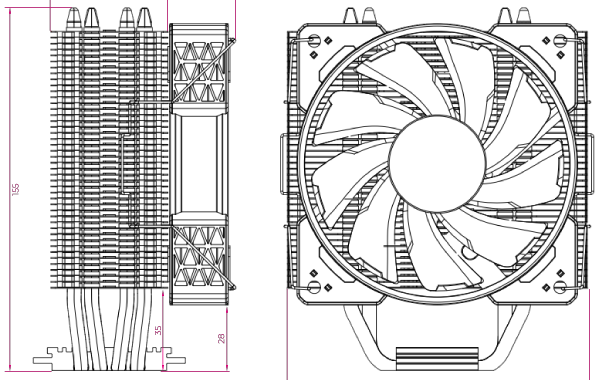

In [2]:
# Pallete
# Props to @sergiosaharovskiy

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
df.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
original.drop(columns='UDI', inplace=True)

df.head(3)

Product ID Type  Air temperature [K]  Process temperature [K]  \
0     L50096    L                300.6                    309.6   
1     M20343    M                302.6                    312.1   
2     L49454    L                299.3                    308.5   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0

According to the documentation of the *AI4I 2020 Predictive Maintenance Dataset*

* **Type**: consisting of a letter L, M, or H for low, medium and high as product quality variants.
* **air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
* **process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
* **rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise.
* **torque [Nm]**: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
* **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
* **machine failure**: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
1. **tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.
2. **heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm.
3. **power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.
4. **overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.
5. **random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 13.5+ MB


In [5]:
df.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
        .background_gradient(subset=['std'], cmap='Blues')\
        .background_gradient(subset=['50%'], cmap='BuGn')

In [6]:
def drop_missing_rows(df):
    if df.isnull().any().any():
        print("Missing values found in the dataframe.")
        df = df.dropna(axis=0)
        dropped_rows = len(df) - len(df.dropna())
        print(f"Dropped {dropped_rows} rows.")
    else:
        print("No missing values found in the dataframe.")

    return df

df = drop_missing_rows(df)
test = drop_missing_rows(test)

No missing values found in the dataframe.
No missing values found in the dataframe.


In [7]:
def count_duplicate_rows(df):
    duplicate_rows = df[df.duplicated()]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe.")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe.")

    return df

df = count_duplicate_rows(df)
test = count_duplicate_rows(test)

Duplicate rows found in the dataframe.
Count of duplicate rows: 1134.
Duplicate rows found in the dataframe.
Count of duplicate rows: 523.


In [8]:
target_col = 'Machine failure'

num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

binary_cols = [
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

cat_cols = 'Type'
cat_columns = ['Type']

## **Initial Analysis**
***

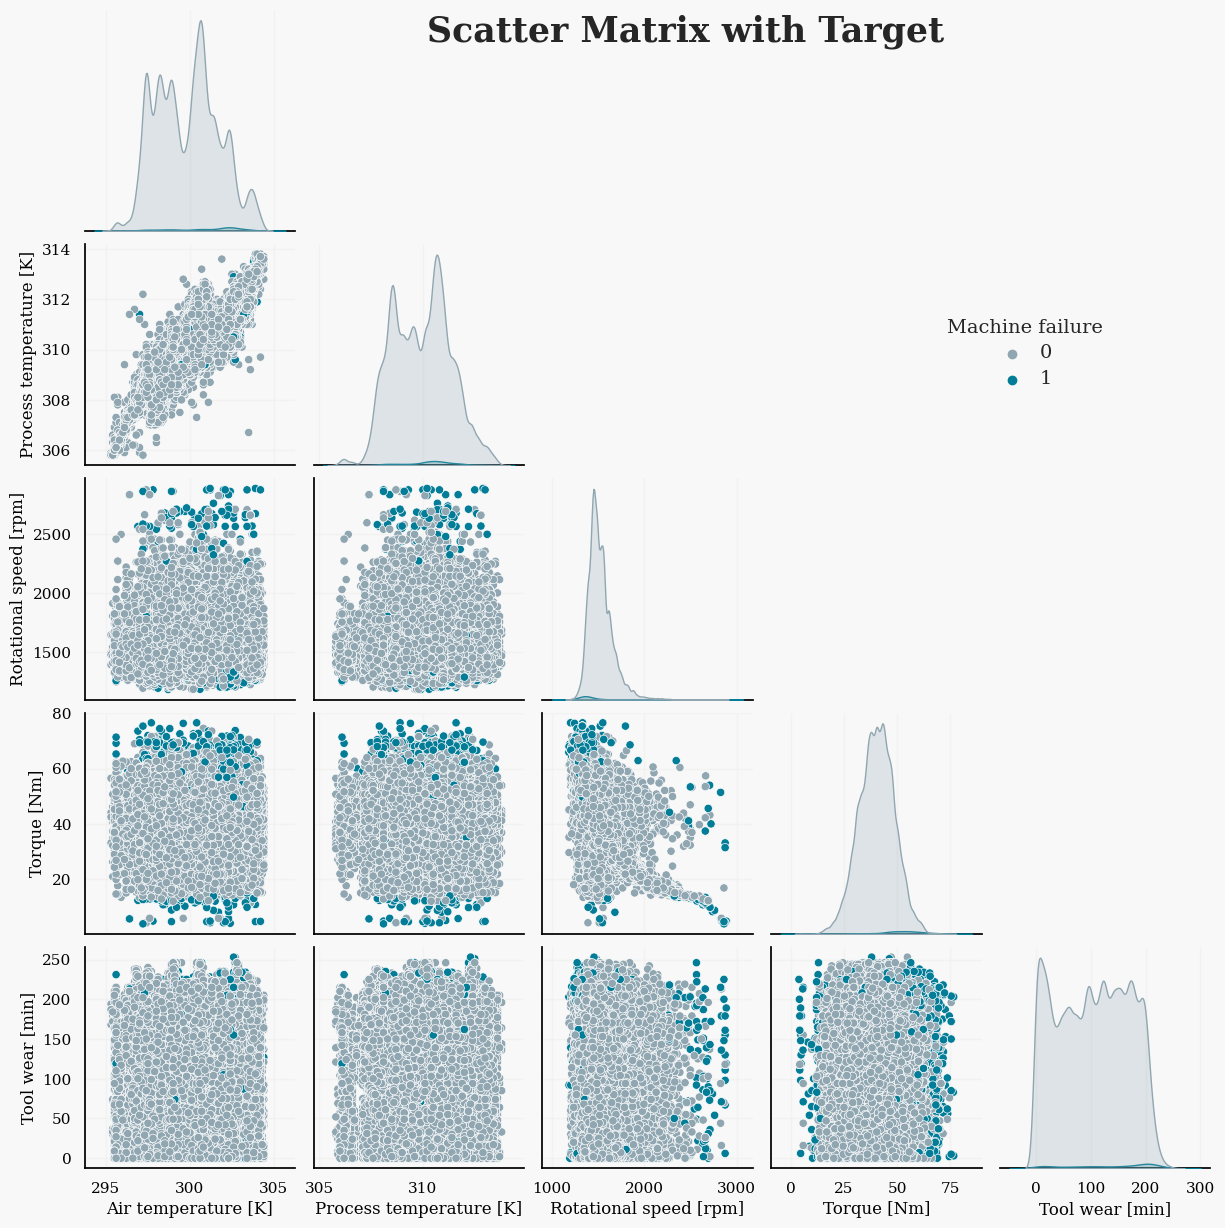

In [9]:
c = ['#90A6B1', '#037d97']

g = sns.pairplot(data=df, x_vars=num_cols, y_vars=num_cols, hue=target_col, corner=True, palette=c)

g._legend.set_bbox_to_anchor((0.8, 0.7))
g._legend.set_title(target_col)
g._legend.loc = 'upper center'
g._legend.get_title().set_fontsize(14)
for item in g._legend.get_texts():
    item.set_fontsize(14)

plt.suptitle(f'Scatter Matrix with Target\n\n', ha='center', fontweight='bold', fontsize=25, y=0.98)
plt.show()

Key points:
* There is a positive linear relationship between Air Temperature and Process Temperature
* There is a negative linear relationship between Rotational Speed and Torque
* Machine Failure is heavily imbalanced
* All the relationships between the features and their distributions were already implied by the problem context, so there are no surprises here

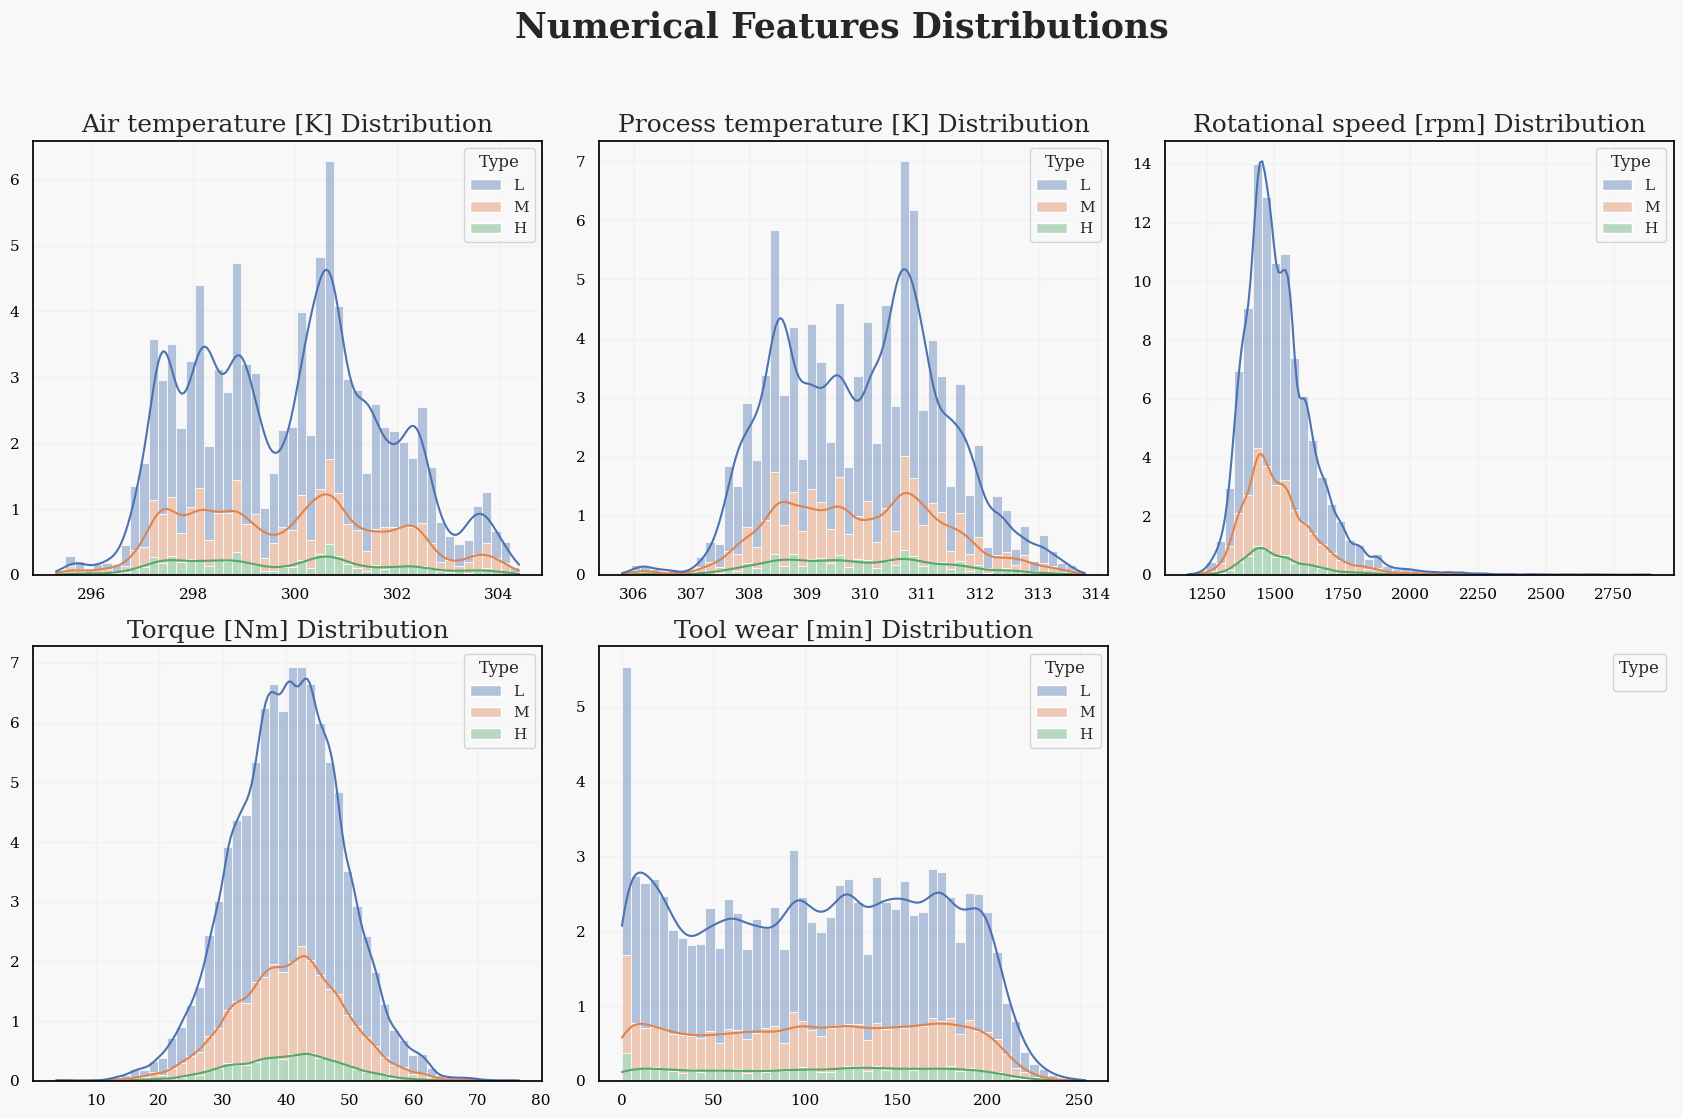

In [10]:
features = [f for f in df.columns if f in num_cols]
n_bins = 50
histplot_hyperparams = {
    'kde': True,
    'alpha': 0.4,
    'stat': 'percent',
    'bins': n_bins
}

columns = features
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 12))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]

    sns.histplot(
        df,
        x=column,
        hue=cat_cols,
        multiple="stack",
        ax=ax[i],
        color=palette[1],
        **histplot_hyperparams
    )
        
    for artist in plot_axes[0].artists:
        if isinstance(artist, sns.kdeplot):
            artist.remove()

    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)  
    ax[i].set_ylabel(None, fontsize=16)
    
handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, title=cat_cols)

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Numerical Features Distributions\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.93)
plt.tight_layout()
plt.show()

Key points:
* Both Air Temperature and Process Temperature are bimodal
* If needed, Rotational Speed can be easily transformed into a normal-like distribution with box-cox transformation.

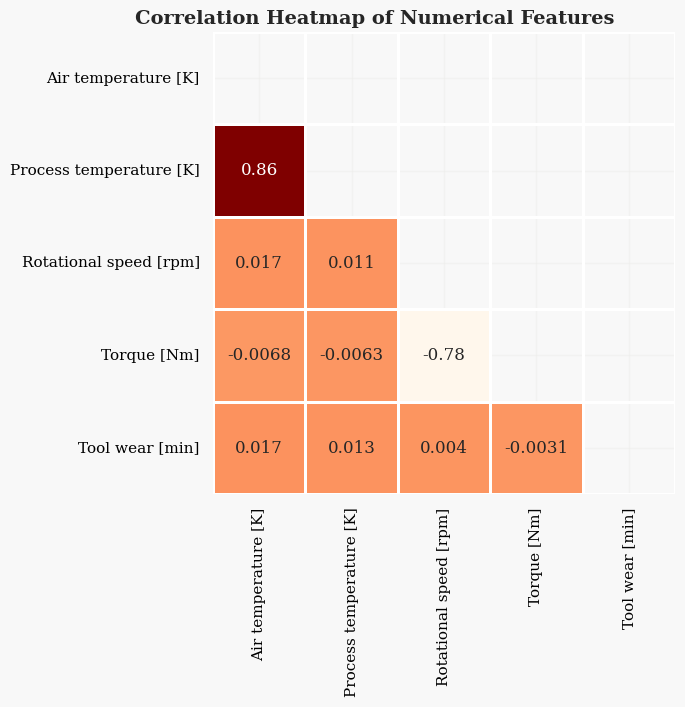

In [11]:
corr_matrix = df[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, square=True, cmap='OrRd', cbar=False, linewidths=1)
title = heatmap.set_title("Correlation Heatmap of Numerical Features", weight='bold', size=14)
title.set_position([0.35, 1.05])
plt.show()

Just confirming what we already know

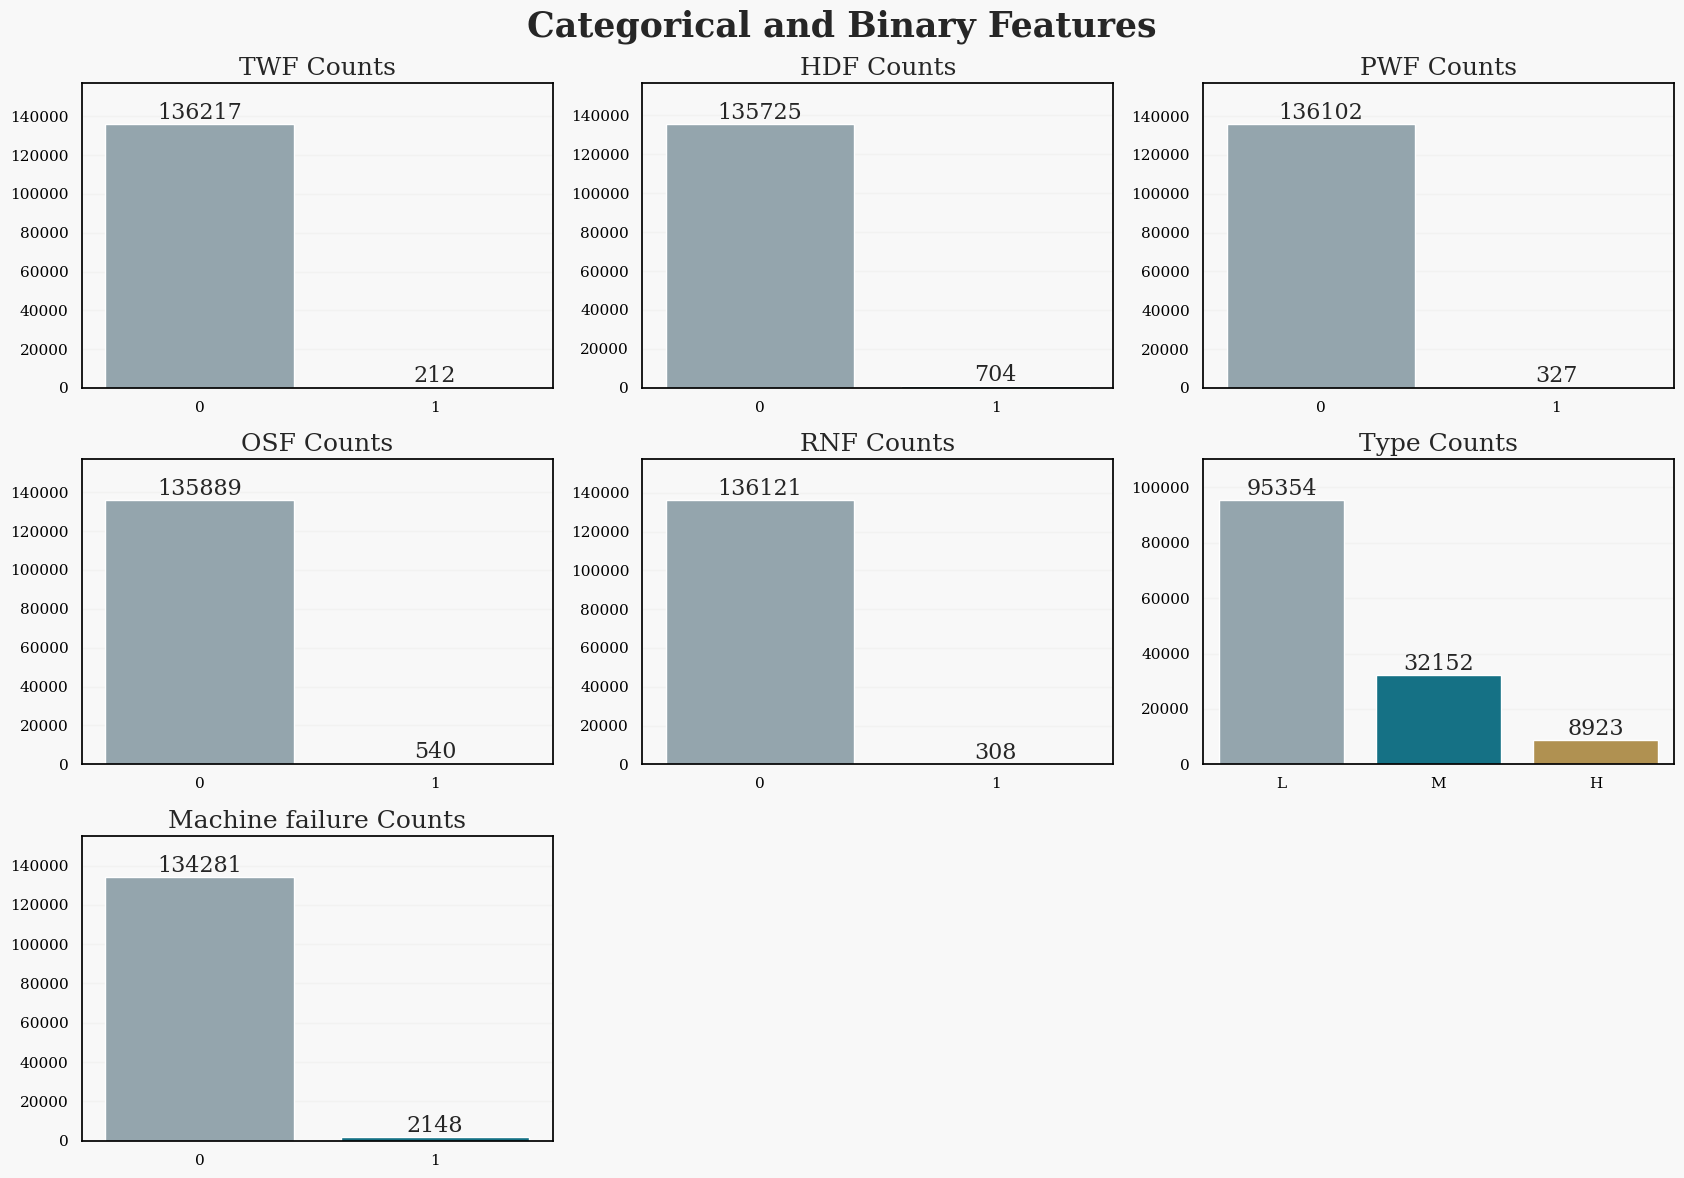

In [12]:
d = ['#90A6B1', '#037d97', '#C09741']

columns = binary_cols + [cat_cols, target_col]
n_cols = 3
n_rows = (len(columns) - 1) // n_cols + 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
ax = ax.flatten()

for i, column in enumerate(columns):
    sns.countplot(data=df, x=column, ax=ax[i], palette=d)
    
    # Titles
    ax[i].set_title(f'{column} Counts', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)

    ax[i].tick_params(axis='x', rotation=0)

    for p in ax[i].patches:
        value = int(p.get_height())
        ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=16)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle('Categorical and Binary Features', fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()

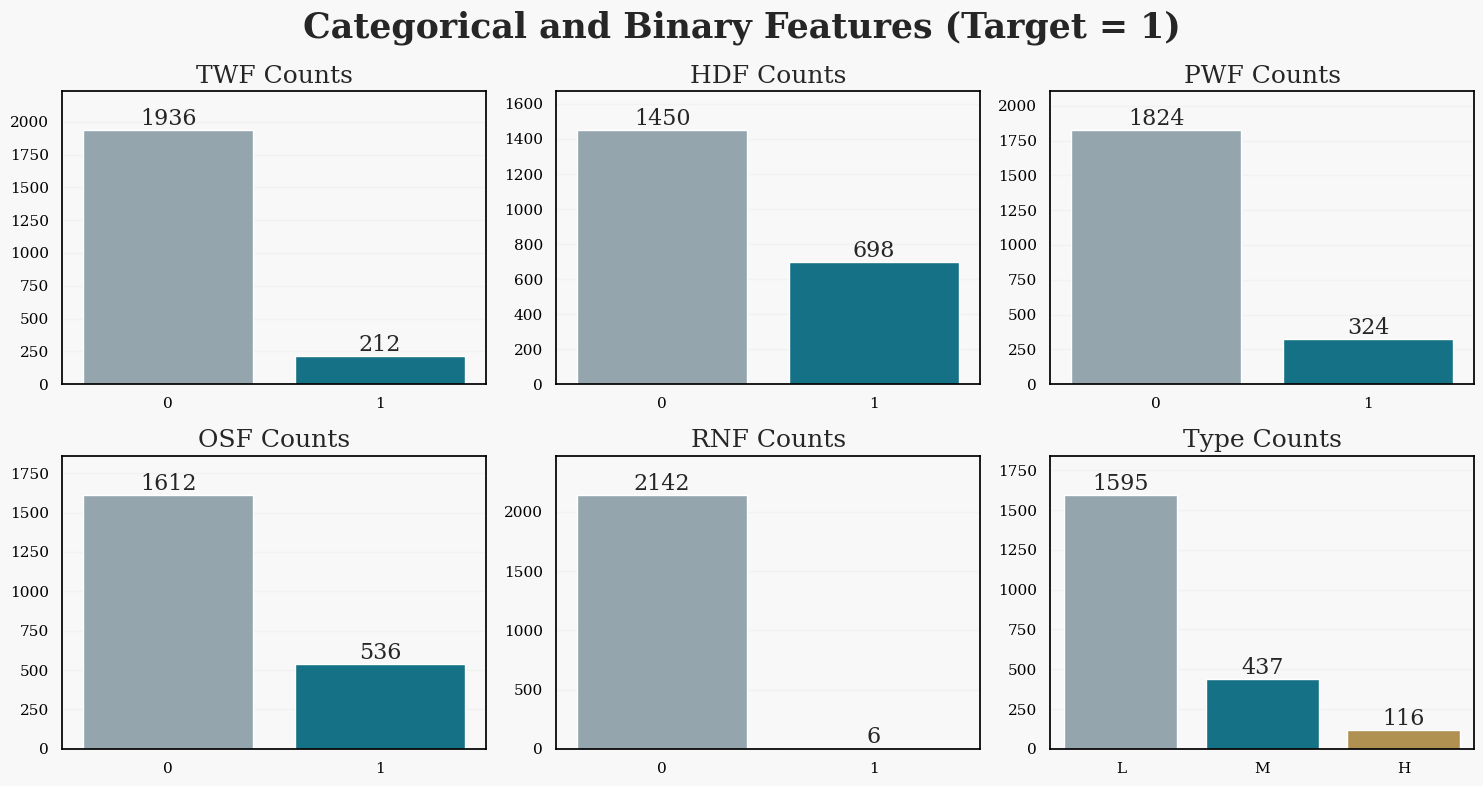

In [13]:
columns = binary_cols + [cat_cols]
n_cols = 3
n_rows = (len(columns) - 1) // n_cols + 1

df_filtered = df[df[target_col] == 1]

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
ax = ax.flatten()

for i, column in enumerate(columns):
    sns.countplot(data=df_filtered, x=column, ax=ax[i], palette=d)
    
    # Titles
    ax[i].set_title(f'{column} Counts', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)

    ax[i].tick_params(axis='x', rotation=0)

    for p in ax[i].patches:
        value = p.get_height()
        ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=16)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle('Categorical and Binary Features (Target = 1)', fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()

Key points:
* RNF does not appear to be important for our problem
* The distribution of Type seems to be proportional across different values of the target

In [14]:
filtered_df = df[(df[target_col] == 1) & (df[binary_cols].sum(axis=1) == 0)]

d_columns = binary_cols + [target_col]
filtered_df = filtered_df[d_columns]

filtered_df

TWF  HDF  PWF  OSF  RNF  Machine failure
130       0    0    0    0    0                1
228       0    0    0    0    0                1
888       0    0    0    0    0                1
1518      0    0    0    0    0                1
1806      0    0    0    0    0                1
...     ...  ...  ...  ...  ...              ...
134865    0    0    0    0    0                1
134955    0    0    0    0    0                1
135097    0    0    0    0    0                1
135570    0    0    0    0    0                1
135957    0    0    0    0    0                1

[507 rows x 6 columns]

Key points:
* It is important to note that there are instances when the machine had failure even if one of the failure modes did not trigger.
* There might be an unknown failure mode at play

In [15]:
df.drop(columns='RNF', inplace=True)

## **Failure Modes**
***

1) **Tool Weear Failure (TWF)** is caused by Tool wear

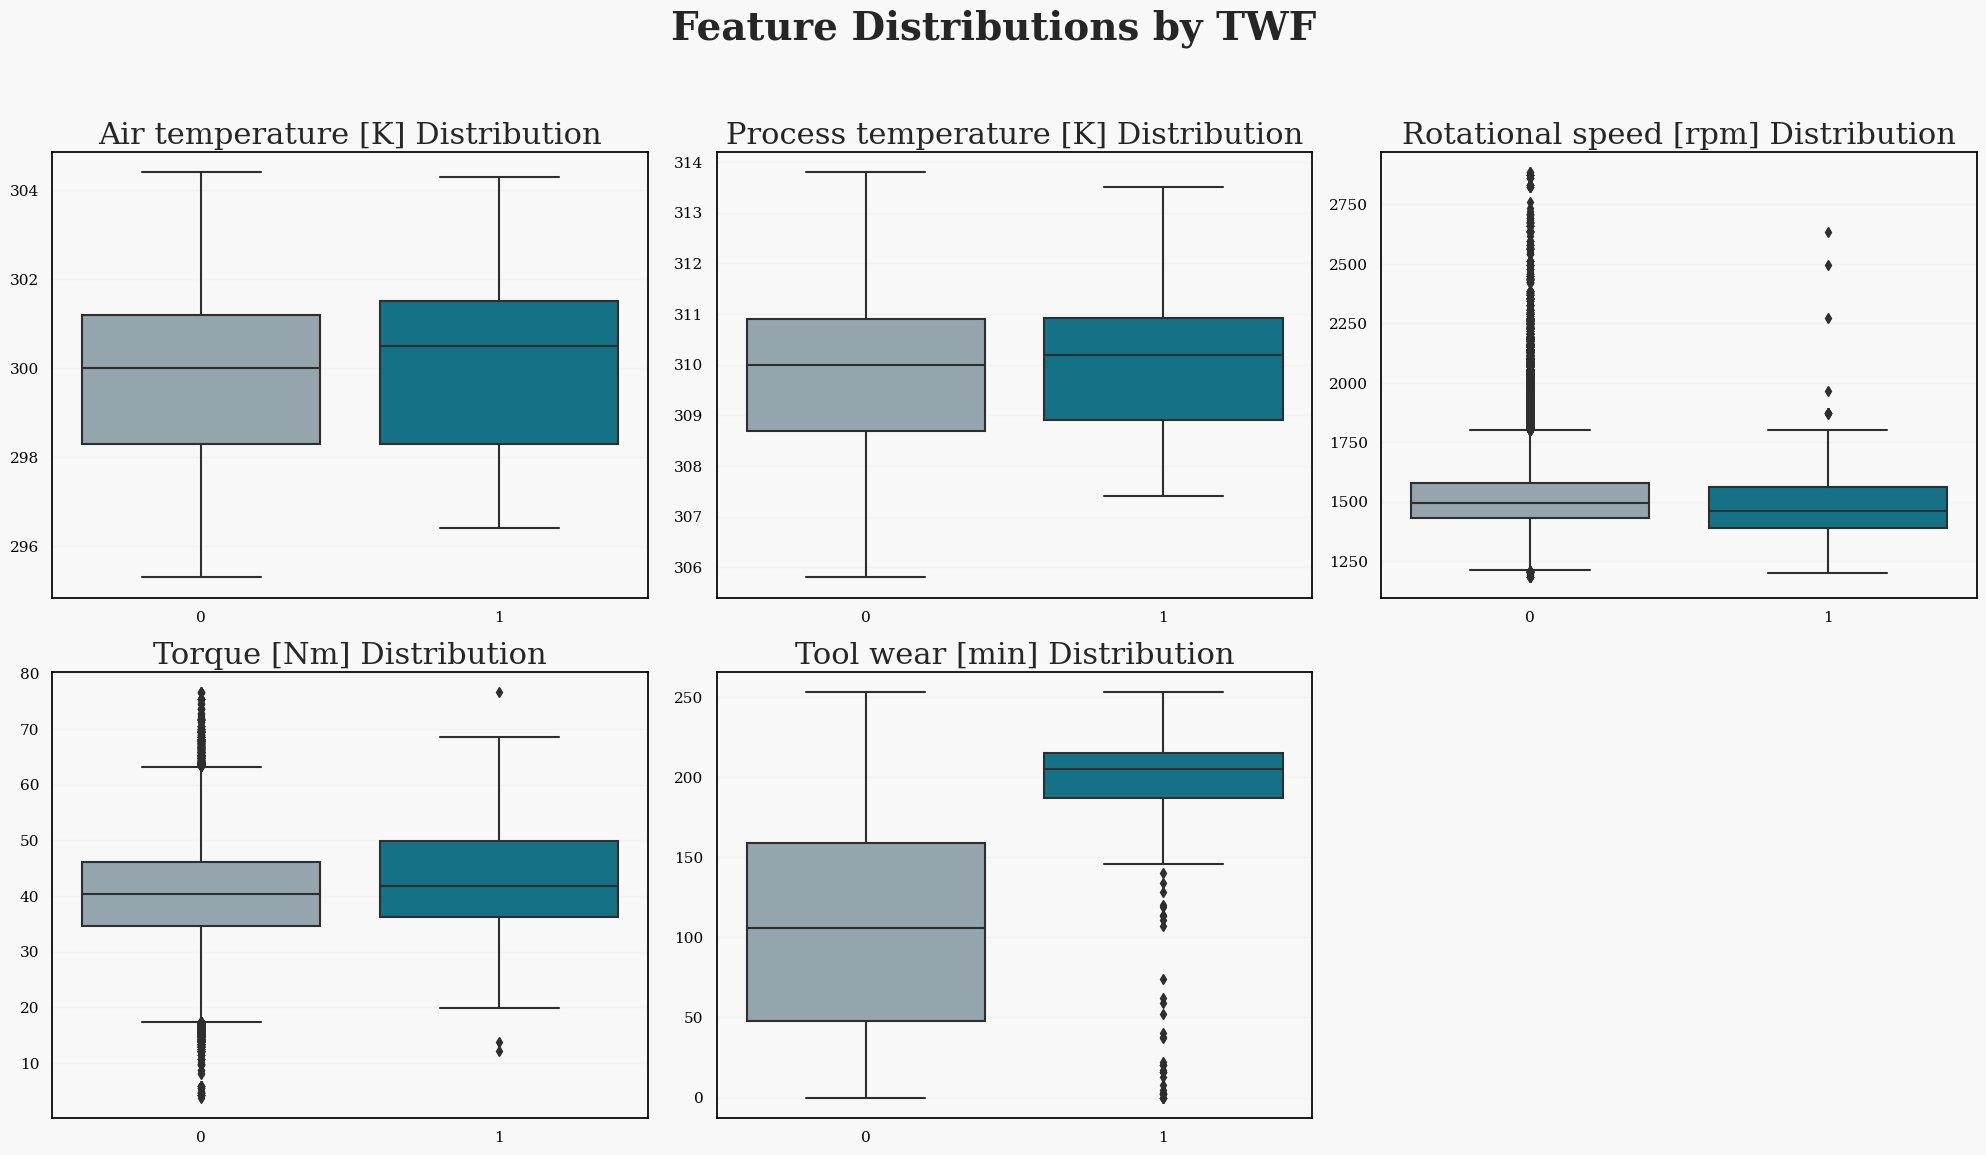

In [16]:
features = [f for f in df.columns if f in num_cols]
columns = features
n_rows = len(columns) // 3
if len(columns) % 3:
    n_rows += 1

fig, ax = plt.subplots(n_rows, 3, figsize=(20, 6 * n_rows))
ax = ax.ravel()

unique_target = df['TWF'].unique()
n_categories = len(unique_target)
colors = sns.color_palette(c, n_categories)

for i, column in enumerate(columns):
    data = [df[df['TWF'] == target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    ax[i].set_title(f'{column} Distribution', fontsize=22)
    ax[i].set_xlabel(None, fontsize=18)
    ax[i].set_ylabel(None, fontsize=18)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by TWF\n\n', ha='center', fontweight='bold', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

* As expected, the only box plot that shows significant difference is Tool Wear
* The low variance in Tool Wear is due to the limited range of values that cause TWF

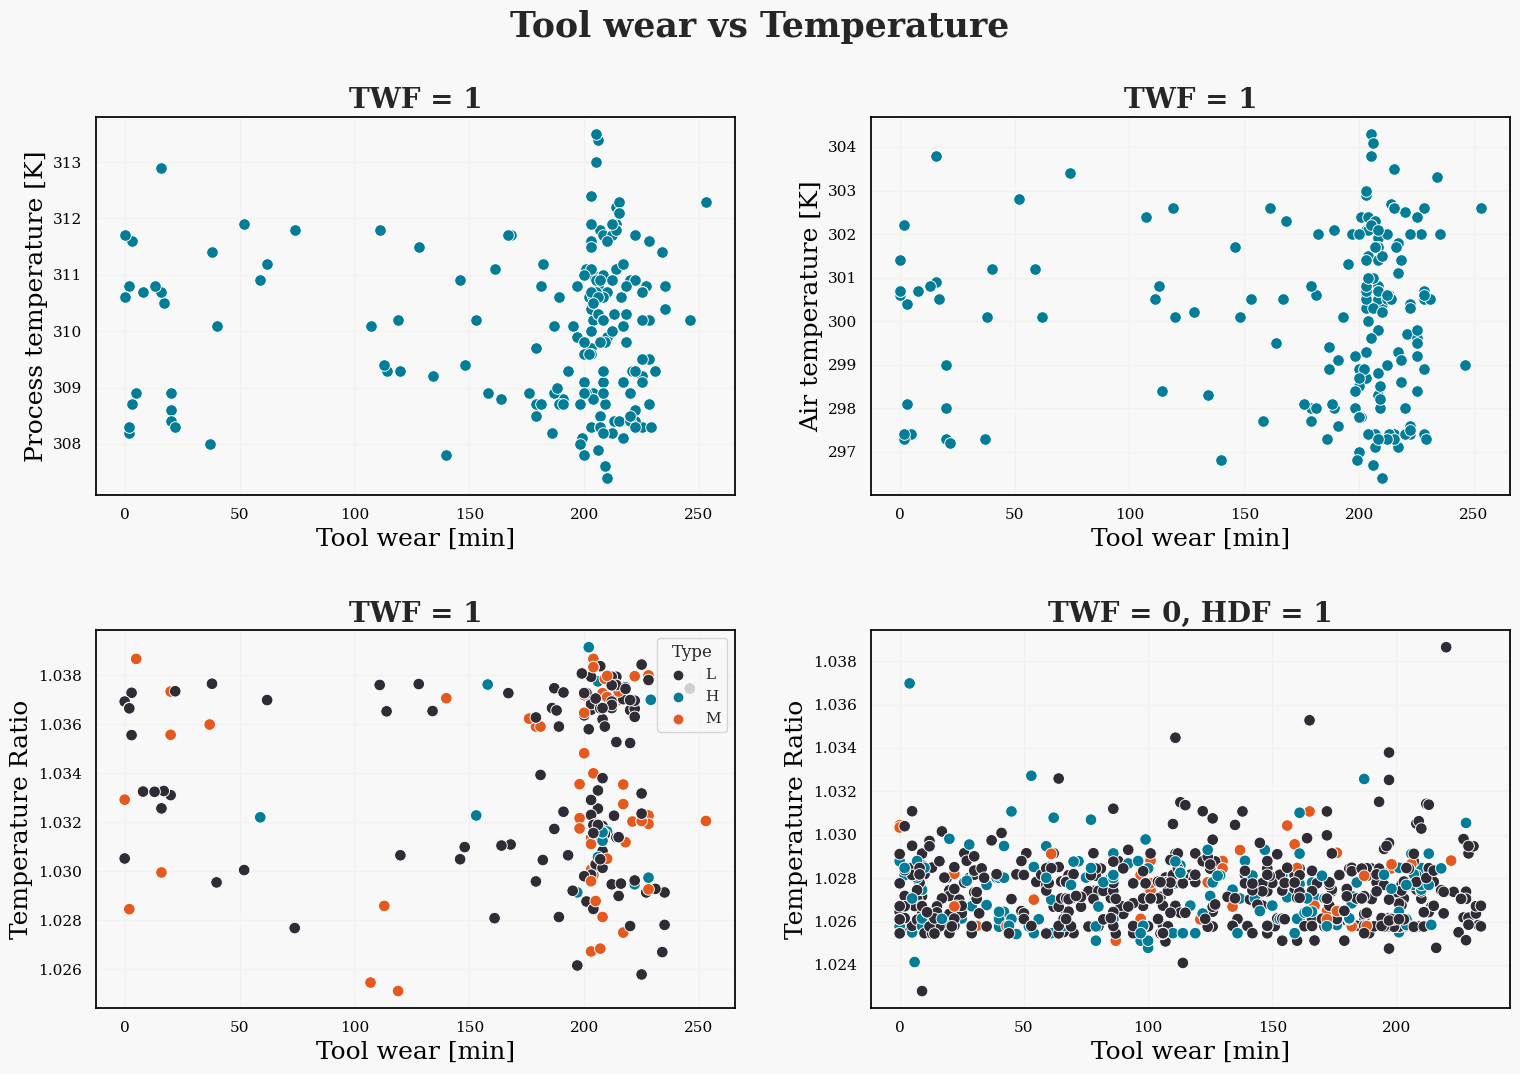

In [17]:
df['tool_process'] = df['Tool wear [min]'] * df['Process temperature [K]']
df['tool_air'] = df['Tool wear [min]'] * df['Air temperature [K]']
df['temp_ratio'] = df['Process temperature [K]'] / df['Air temperature [K]']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(data=df[df['TWF'] == 1], x='Tool wear [min]', y='Process temperature [K]',
                color='#037d97', ax=axes[0, 0], s=70, antialiased=True)
axes[0, 0].set_title('TWF = 1', fontsize=20, fontweight='bold')
axes[0, 0].set_xlabel('Tool wear [min]', fontsize=18)
axes[0, 0].set_ylabel('Process temperature [K]', fontsize=18)

sns.scatterplot(data=df[df['TWF'] == 1], x='Tool wear [min]', y='Air temperature [K]',
                color='#037d97', ax=axes[0, 1], s=70, antialiased=True)
axes[0, 1].set_title('TWF = 1', fontsize=20, fontweight='bold')
axes[0, 1].set_xlabel('Tool wear [min]', fontsize=18)
axes[0, 1].set_ylabel('Air temperature [K]', fontsize=18)

sns.scatterplot(data=df[df['TWF'] == 1], x='Tool wear [min]', y='temp_ratio', hue='Type',
                palette=palette, ax=axes[1, 0], s=70, antialiased=True)
axes[1, 0].set_title('TWF = 1', fontsize=20, fontweight='bold')
axes[1, 0].set_xlabel('Tool wear [min]', fontsize=18)
axes[1, 0].set_ylabel('Temperature Ratio', fontsize=18)

sns.scatterplot(data=df[(df['TWF'] == 0) & ((df['HDF'] == 1))], x='Tool wear [min]', y='temp_ratio', hue='Type',
                palette=palette, ax=axes[1, 1], s=70, antialiased=True, legend=False)
axes[1, 1].set_title('TWF = 0, HDF = 1', fontsize=20, fontweight='bold')
axes[1, 1].set_xlabel('Tool wear [min]', fontsize=18)
axes[1, 1].set_ylabel('Temperature Ratio', fontsize=18)

fig.suptitle(f'Tool wear vs Temperature\n', ha='center',
             fontweight='bold', fontsize=25, y=0.92)

plt.tight_layout(pad=3)
plt.show()

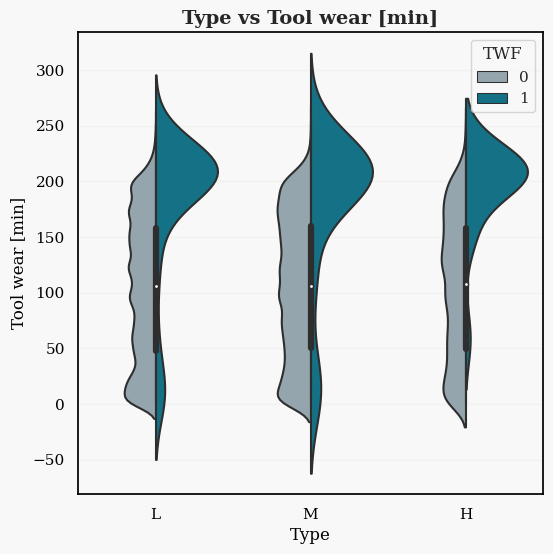

ANOVA Test Results:
F-statistic: 3.3949164578041544
p-value: 0.03354619015995314

There is evidence of a significant difference in the means of 'Tool wear [min]' across different values of 'Type'.

Levene's Test Results:
Test statistic: 8.15951222197882
p-value: 0.00028614146175158137

There is evidence of a significant difference in the variances of 'Tool wear [min]' across different values of 'Type'.


In [18]:
import scipy.stats as stats

df_twf = df[['Type', 'Tool wear [min]', 'TWF']]

plt.figure(figsize=(6, 6))
sns.violinplot(data=df_twf, x='Type', y='Tool wear [min]', hue='TWF', split=True, palette=c)
plt.title('Type vs Tool wear [min]', fontsize=14, fontweight='bold')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Tool wear [min]', fontsize=12)
plt.legend(title='TWF', loc='upper right')
plt.show()

# one-way ANOVA test
result_anova = stats.f_oneway(*(df_twf[df_twf['Type'] == t]['Tool wear [min]'] for t in df_twf['Type'].unique()))

print("ANOVA Test Results:")
print("F-statistic:", result_anova.statistic)
print("p-value:", result_anova.pvalue)
print()

alpha = 0.05  # Significance level

if result_anova.pvalue < alpha:
    print("There is evidence of a significant difference in the means of 'Tool wear [min]' across different values of 'Type'.")
else:
    print("There is no significant difference in the means of 'Tool wear [min]' across different values of 'Type'.")
print()

# Levene's test
result_levene = stats.levene(*(df_twf[df_twf['Type'] == t]['Tool wear [min]'] for t in df_twf['Type'].unique()))

print("Levene's Test Results:")
print("Test statistic:", result_levene.statistic)
print("p-value:", result_levene.pvalue)
print()

alpha = 0.05  # Significance level

if result_levene.pvalue < alpha:
    print("There is evidence of a significant difference in the variances of 'Tool wear [min]' across different values of 'Type'.")
else:
    print("There is no significant difference in the variances of 'Tool wear [min]' across different values of 'Type'.")

Key points:
* Tool wear values are symmetrically distributed around the mean when TWF occurs

***

2) **Heat Dissipation Failure (HDF)** causes a process failure if:
* The difference between air and process temperature is below 8.6 K 
* The rotational speed is below 1380 rpm

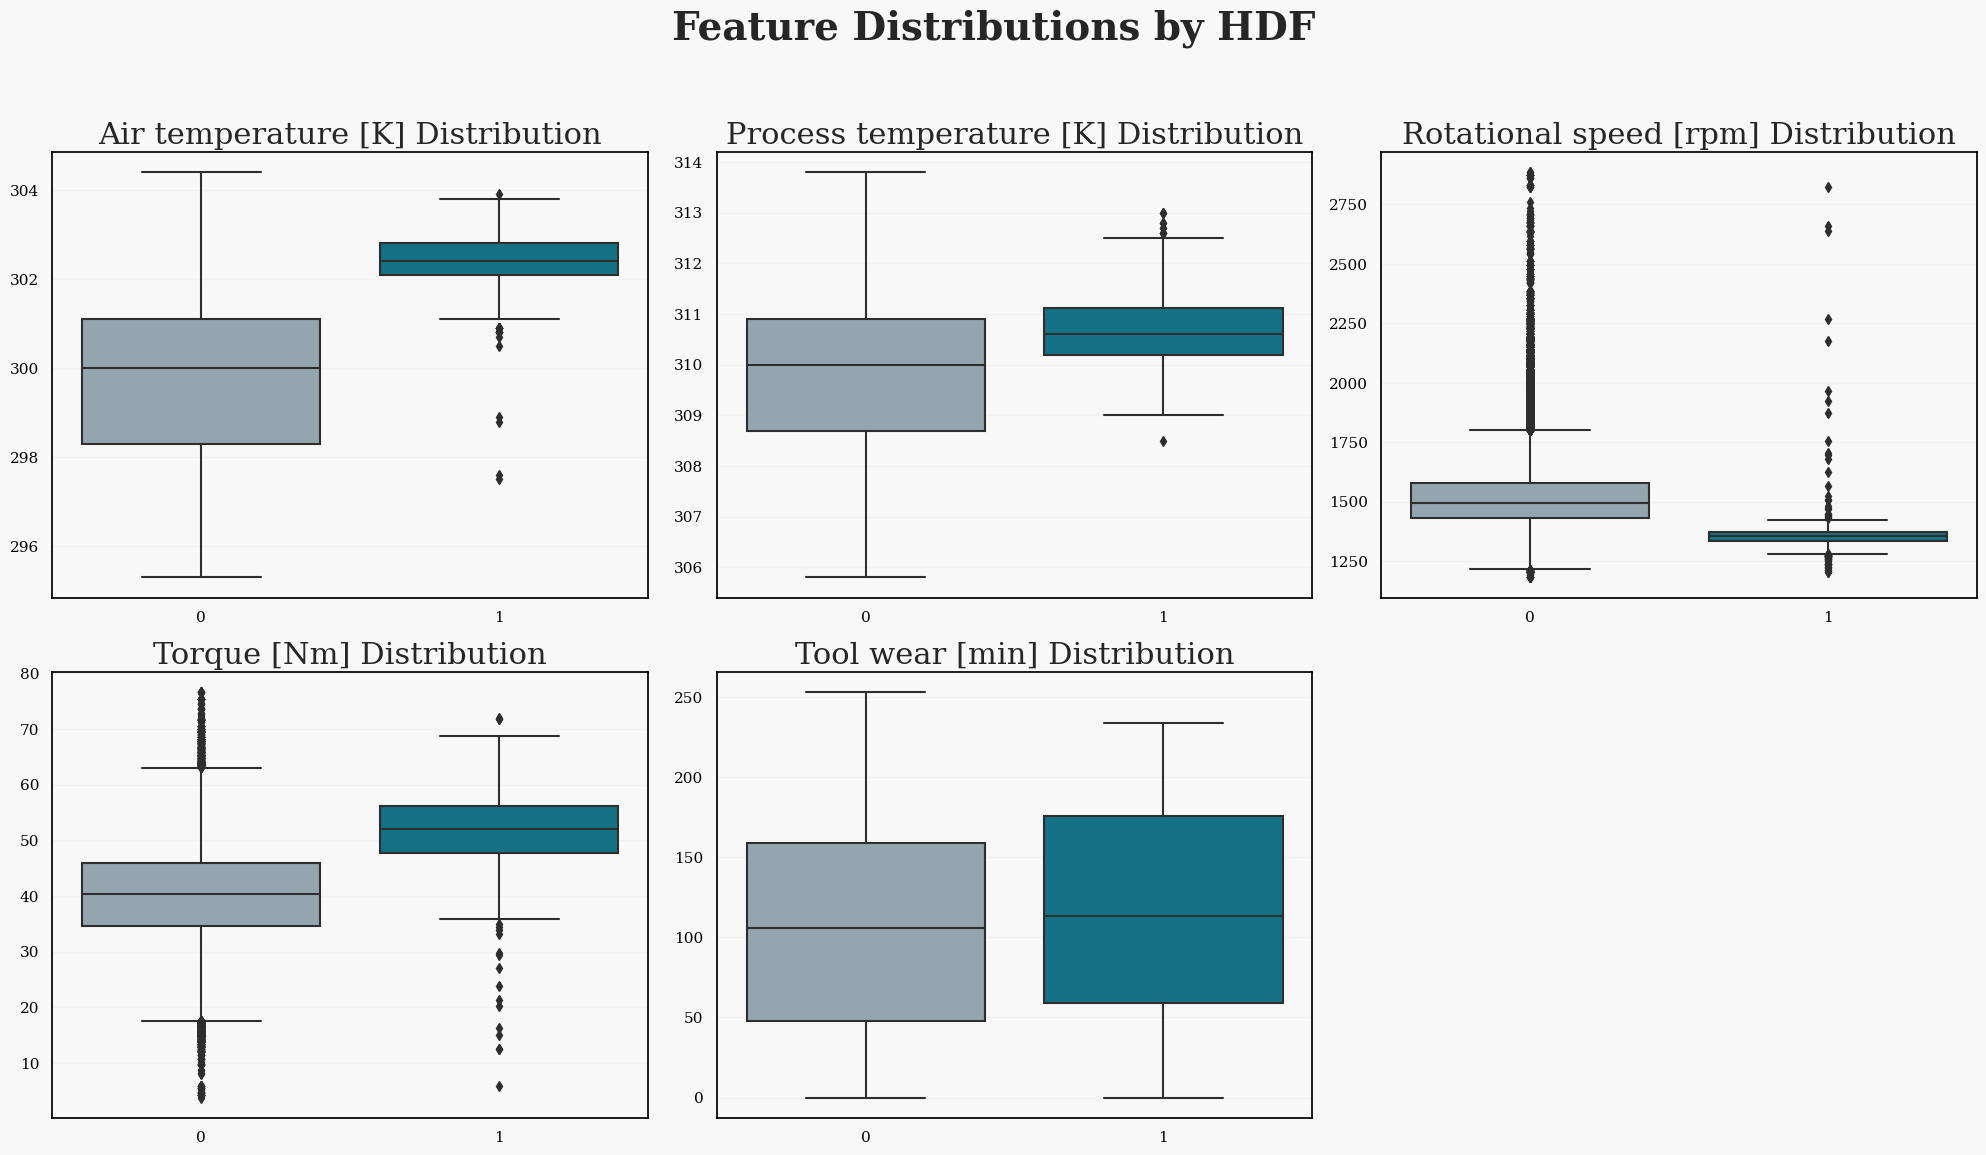

In [19]:
features = [f for f in df.columns if f in num_cols]
columns = features
n_rows = len(columns) // 3
if len(columns) % 3:
    n_rows += 1

fig, ax = plt.subplots(n_rows, 3, figsize=(20, 6 * n_rows))
ax = ax.ravel()

unique_target = df['HDF'].unique()
n_categories = len(unique_target)
colors = sns.color_palette(c, n_categories)

for i, column in enumerate(columns):
    data = [df[df['HDF'] == target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=22)
    ax[i].set_xlabel(None, fontsize=16)
    ax[i].set_ylabel(None, fontsize=16)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by HDF\n\n', ha='center', fontweight='bold', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

* HDF failure is clearly seen by the low variance of it's main causes.
* Higher median temperature values for failure are also expected due to the positive linear relationship between air temperature and process temperature.
* low rotational speed causes HDF failure, resulting in high torque as a consequence.
* In conclusion, HDF interacts with four features. 

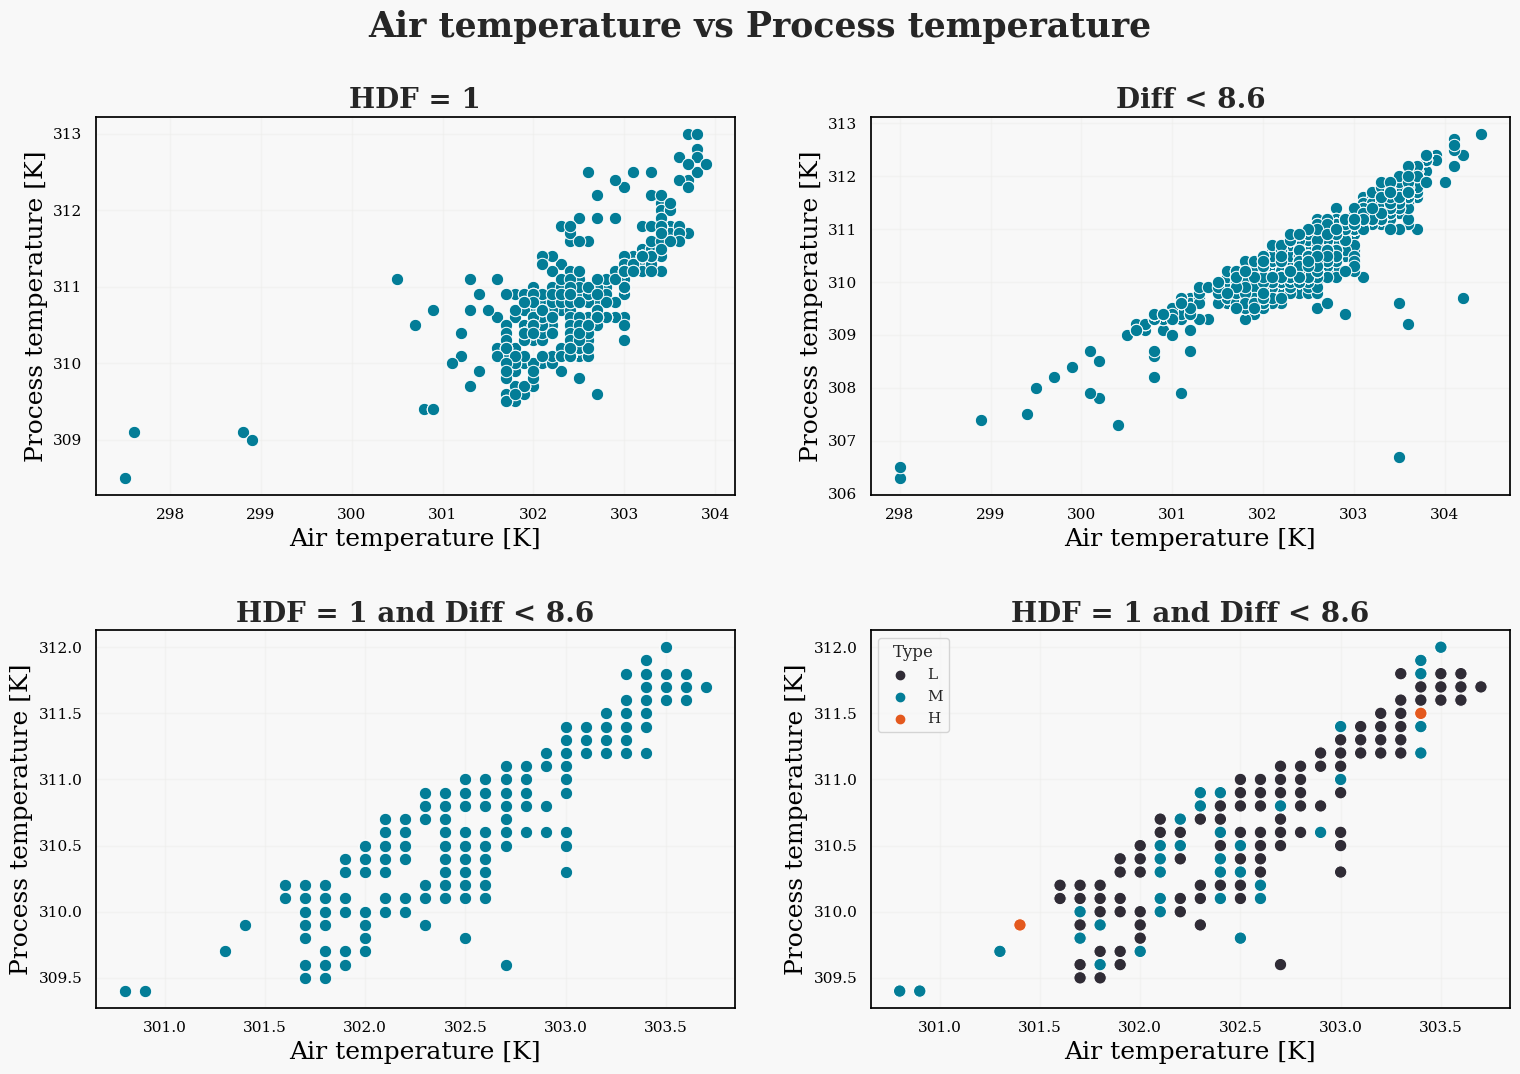

In [20]:
df['air_process_diff'] = abs(df['Air temperature [K]'] - df['Process temperature [K]'])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(data=df[df['HDF'] == 1], x='Air temperature [K]', y='Process temperature [K]',
                color='#037d97', ax=axes[0, 0], s=80)
axes[0, 0].set_title('HDF = 1', fontsize=20, fontweight='bold')
axes[0, 0].set_xlabel('Air temperature [K]', fontsize=18)
axes[0, 0].set_ylabel('Process temperature [K]', fontsize=18)

sns.scatterplot(data=df[df['air_process_diff'] < 8.6], x='Air temperature [K]', y='Process temperature [K]',
                color='#037d97', ax=axes[0, 1], s=80)
axes[0, 1].set_title('Diff < 8.6', fontsize=20, fontweight='bold')
axes[0, 1].set_xlabel('Air temperature [K]', fontsize=18)
axes[0, 1].set_ylabel('Process temperature [K]', fontsize=18)

sns.scatterplot(data=df[(df['air_process_diff'] < 8.6) & (df['HDF'] == 1)], x='Air temperature [K]', y='Process temperature [K]',
                color='#037d97', ax=axes[1, 0], s=80)
axes[1, 0].set_title('HDF = 1 and Diff < 8.6', fontsize=20, fontweight='bold')
axes[1, 0].set_xlabel('Air temperature [K]', fontsize=18)
axes[1, 0].set_ylabel('Process temperature [K]', fontsize=18)

sns.scatterplot(data=df[(df['air_process_diff'] < 8.6) & (df['HDF'] == 1)], x='Air temperature [K]', y='Process temperature [K]',
                hue="Type", palette=palette, ax=axes[1, 1], s=80)
axes[1, 1].set_title('HDF = 1 and Diff < 8.6', fontsize=20, fontweight='bold')
axes[1, 1].set_xlabel('Air temperature [K]', fontsize=18)
axes[1, 1].set_ylabel('Process temperature [K]', fontsize=18)

fig.suptitle(f'Air temperature vs Process temperature\n', ha='center',
             fontweight='bold', fontsize=25, y=0.92)

plt.tight_layout(pad=3)
plt.show()

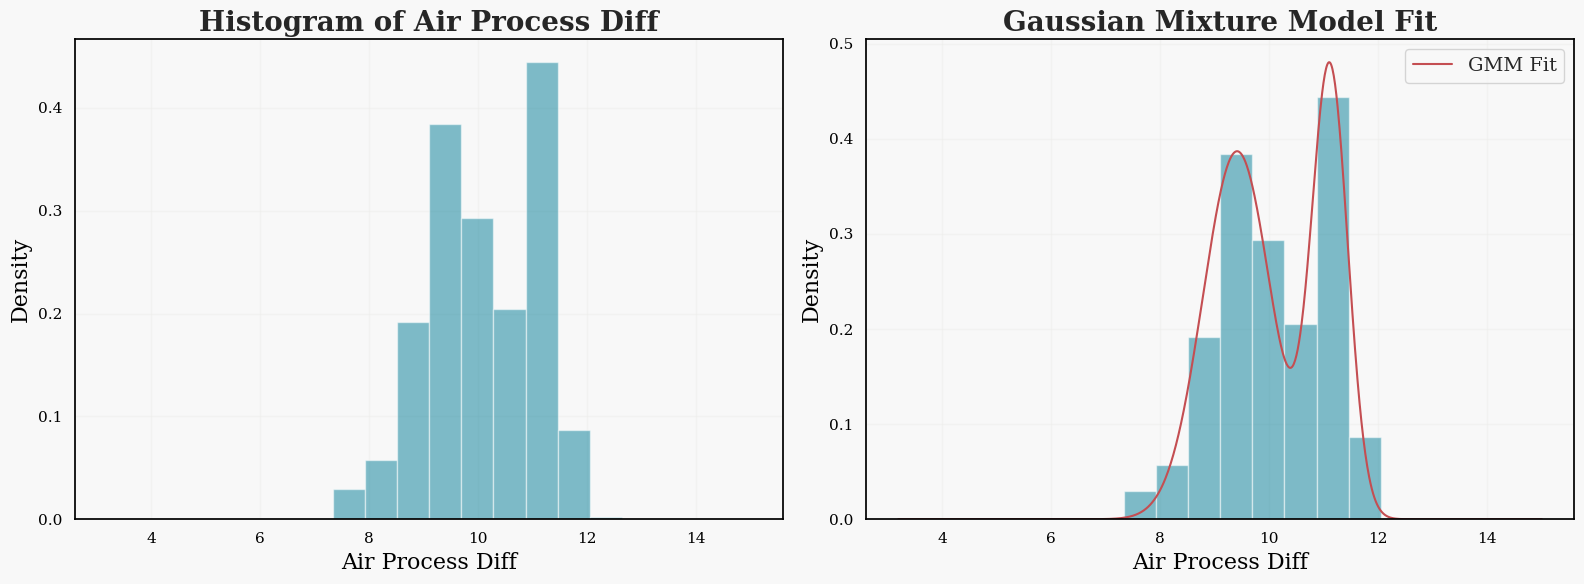

In [21]:
from sklearn.mixture import GaussianMixture

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(data=df, x='air_process_diff', bins=20, density=True, color='#037d97', alpha=0.5)
axs[0].set_title('Histogram of Air Process Diff', fontsize=20, fontweight='bold')
axs[0].set_xlabel('Air Process Diff', fontsize=16)
axs[0].set_ylabel('Density', fontsize=16)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(df['air_process_diff'].values.reshape(-1, 1))

means = gmm.means_
covariances = gmm.covariances_

x = np.linspace(df['air_process_diff'].min(), df['air_process_diff'].max(), 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

axs[1].hist(df['air_process_diff'], bins=20, density=True, color='#037d97', alpha=0.5)
axs[1].plot(x, pdf, '-r', label='GMM Fit')
axs[1].set_title('Gaussian Mixture Model Fit', fontsize=20, fontweight='bold')
axs[1].set_xlabel('Air Process Diff', fontsize=16)
axs[1].set_ylabel('Density', fontsize=16)
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

As we stated before, the Air Temperature and Process Temperature follow a bimodal distribution. The difference between them forms a cleaner bimodal shape. A Gaussian Mixture Model fits perfectly when n_components = 2, strongly suggesting that these distributions indeed have two distinct groups within them

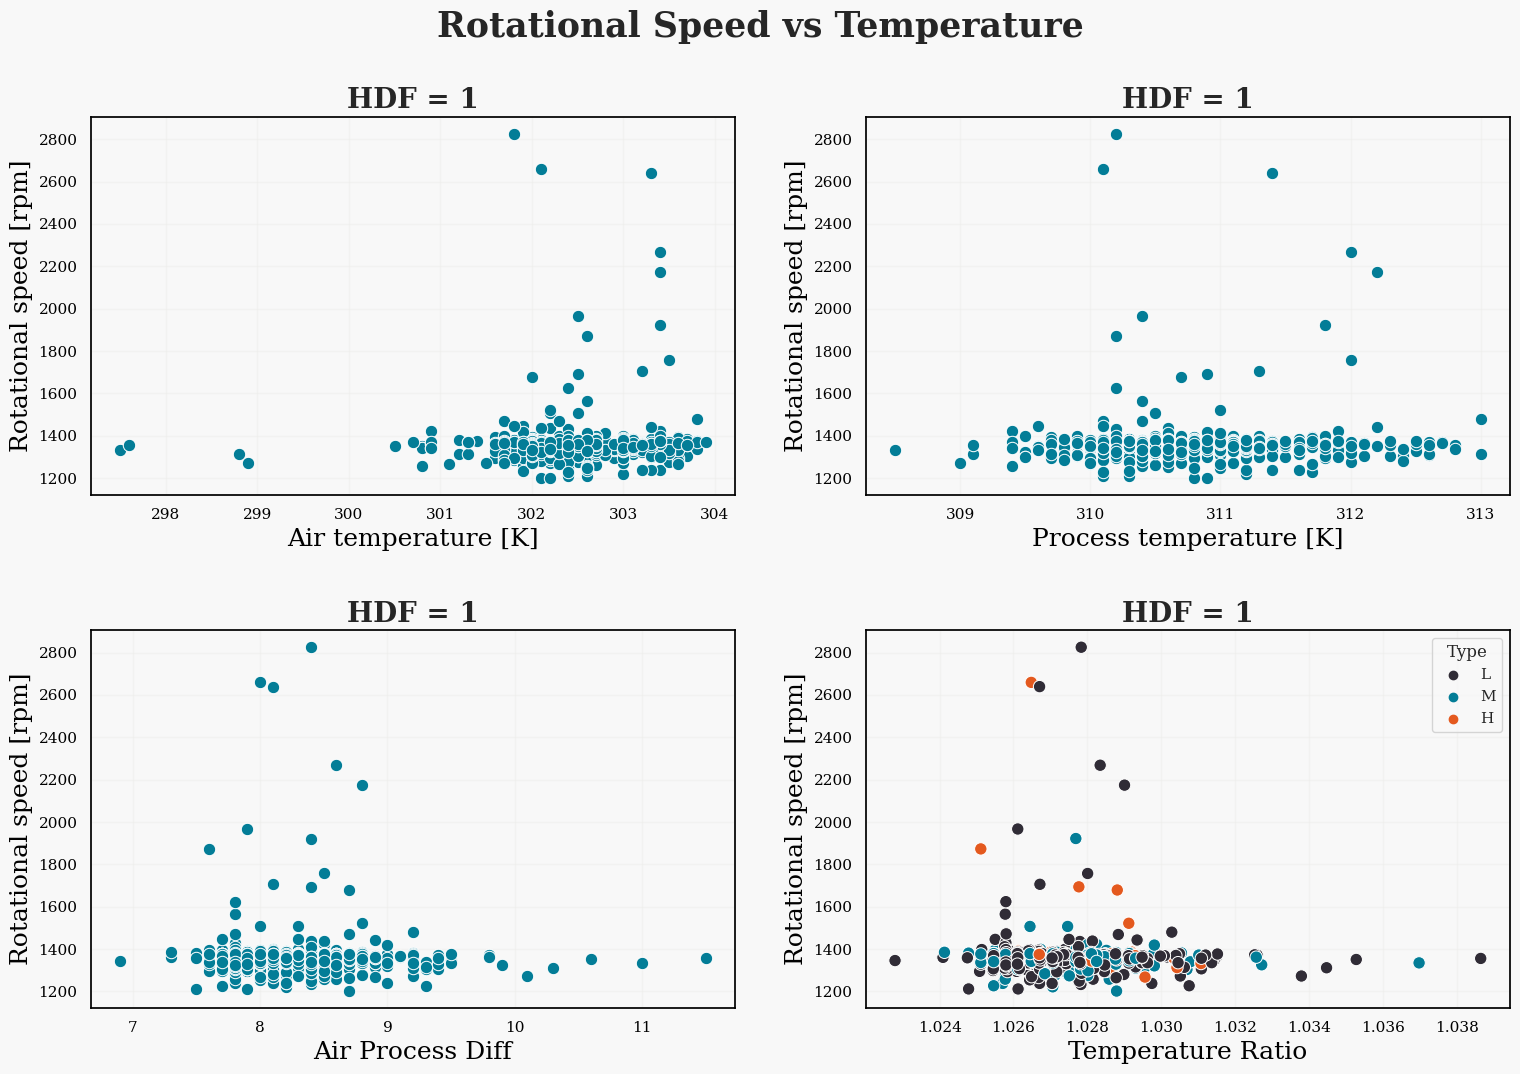

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(data=df[df['HDF'] == 1], x='Air temperature [K]', y='Rotational speed [rpm]',
                color='#037d97', ax=axes[0, 0], s=80)
axes[0, 0].set_title('HDF = 1', fontsize=20, fontweight='bold')
axes[0, 0].set_xlabel('Air temperature [K]', fontsize=18)
axes[0, 0].set_ylabel('Rotational speed [rpm]', fontsize=18)

sns.scatterplot(data=df[df['HDF'] == 1], x='Process temperature [K]', y='Rotational speed [rpm]',
                color='#037d97', ax=axes[0, 1], s=80)
axes[0, 1].set_title('HDF = 1', fontsize=20, fontweight='bold')
axes[0, 1].set_xlabel('Process temperature [K]', fontsize=18)
axes[0, 1].set_ylabel('Rotational speed [rpm]', fontsize=18)

sns.scatterplot(data=df[df['HDF'] == 1], x='air_process_diff', y='Rotational speed [rpm]',
                color='#037d97', ax=axes[1, 0], s=80)
axes[1, 0].set_title('HDF = 1', fontsize=20, fontweight='bold')
axes[1, 0].set_xlabel('Air Process Diff', fontsize=18)
axes[1, 0].set_ylabel('Rotational speed [rpm]', fontsize=18)

sns.scatterplot(data=df[df['HDF'] == 1], x='temp_ratio', y='Rotational speed [rpm]',
                color='#037d97', ax=axes[1, 1], s=80, hue='Type', palette=palette)
axes[1, 1].set_title('HDF = 1', fontsize=20, fontweight='bold')
axes[1, 1].set_xlabel('Temperature Ratio', fontsize=18)
axes[1, 1].set_ylabel('Rotational speed [rpm]', fontsize=18)

fig.suptitle(f'Rotational Speed vs Temperature\n', ha='center', fontweight='bold', fontsize=25, y=0.92)

plt.tight_layout(pad=3)
plt.show()

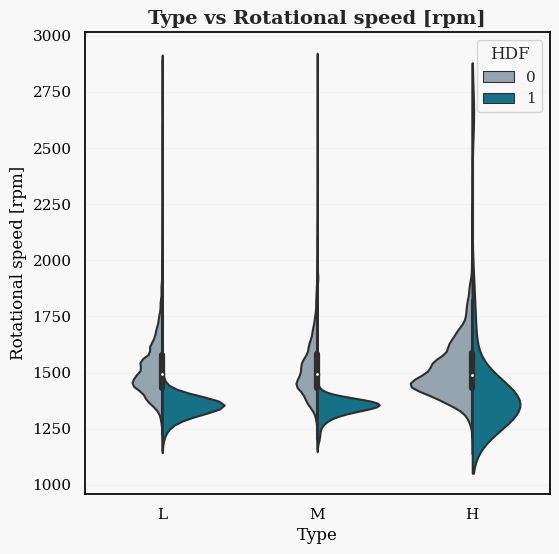

ANOVA Test Results:
F-statistic: 0.5726432601386056
p-value: 0.5640339374004131

There is no significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.

Levene's Test Results:
Test statistic: 17.978682152874903
p-value: 1.55950344615656e-08

There is evidence of a significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.


In [23]:
df_hdf = df[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'HDF']]

plt.figure(figsize=(6, 6))
sns.violinplot(data=df_hdf, x='Type', y='Rotational speed [rpm]', hue='HDF', split=True, palette=c)
plt.title('Type vs Rotational speed [rpm]', fontsize=14, fontweight='bold')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Rotational speed [rpm]', fontsize=12)
plt.legend(title='HDF', loc='upper right')
plt.show()

# one-way ANOVA
result_anova = stats.f_oneway(*(df_hdf[df_hdf['Type'] == t]['Rotational speed [rpm]'] for t in df_hdf['Type'].unique()))

print("ANOVA Test Results:")
print("F-statistic:", result_anova.statistic)
print("p-value:", result_anova.pvalue)
print()

alpha = 0.05  # Significance level

if result_anova.pvalue < alpha:
    print("There is evidence of a significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.")
else:
    print("There is no significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.")
print()

# Levene's test 
result_levene = stats.levene(*(df_hdf[df_hdf['Type'] == t]['Rotational speed [rpm]'] for t in df_hdf['Type'].unique()))

print("Levene's Test Results:")
print("Test statistic:", result_levene.statistic)
print("p-value:", result_levene.pvalue)
print()

alpha = 0.05  # Significance level

if result_levene.pvalue < alpha:
    print("There is evidence of a significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.")
else:
    print("There is no significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.")

We can theorize that the reason why we see normal shape for rotational speed when HDF happens is the same as the reason why tear wear follows a normal distribuction when TWF happens.

Both might be attributed to the Central Limit Theorem. In the case of TWF, tool wear is the result of a large number of small, independent, and random wear events. As we saw by the correlation map, tool wear is not influenced by the other features, so the aggregate of the independent factors that cause TWF leads to a normal distribution.

In the case of HDF, the same explanation can be applied. The rotational speed at which heat dissipation failure occurs is influenced by many small, independent factors (examples could be ambient temperature, tool geometry, and so forth). The aggregation of these factors, according to the CLT, will lead to a normal distribution of rotational speeds at which failure occurs.

***

3) **Power Failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

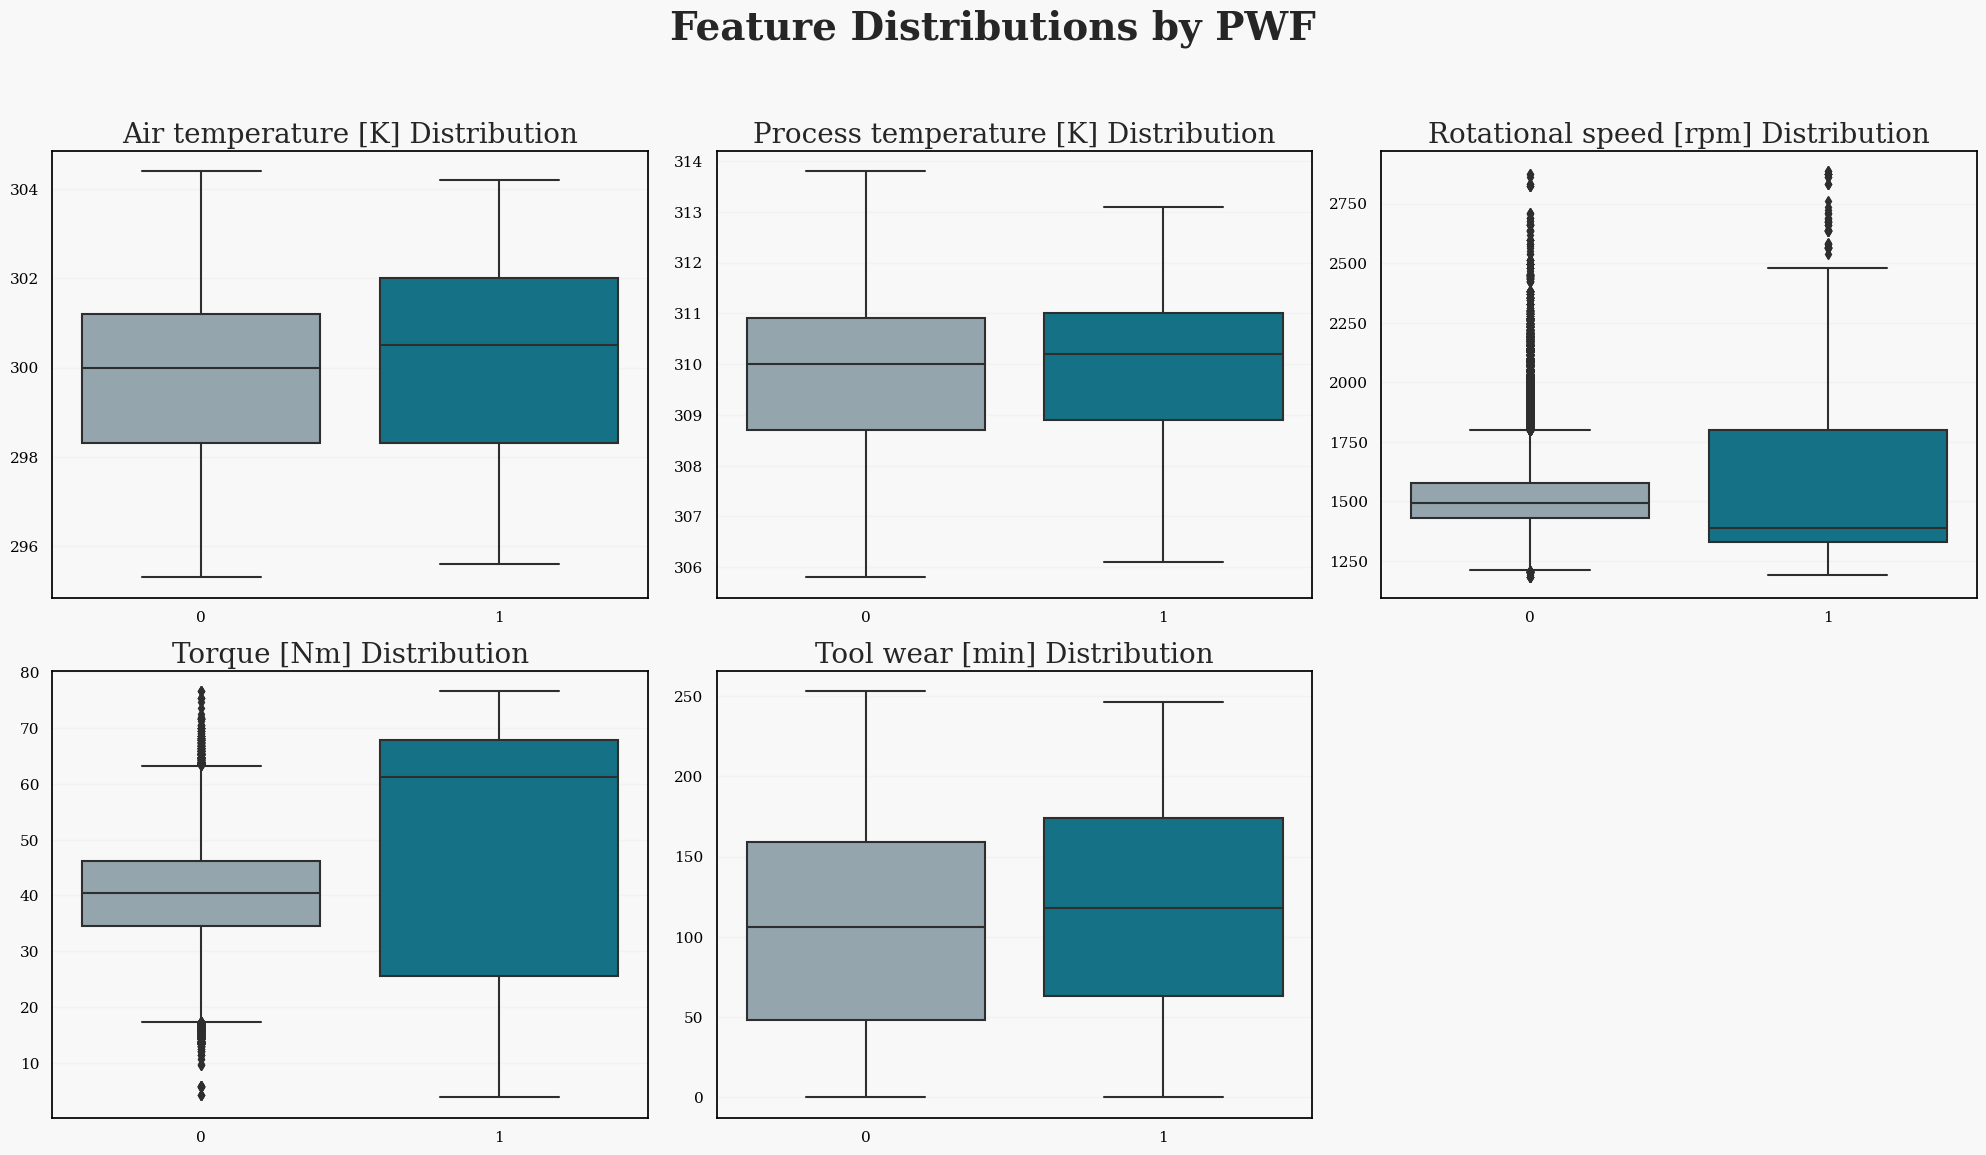

In [24]:
features = [f for f in df.columns if f in num_cols]
columns = features
n_rows = len(columns) // 3
if len(columns) % 3:
    n_rows += 1

fig, ax = plt.subplots(n_rows, 3, figsize=(20, 6 * n_rows))
ax = ax.ravel()

unique_target = df['PWF'].unique()
n_categories = len(unique_target)
colors = sns.color_palette(c, n_categories)

for i, column in enumerate(columns):
    data = [df[df['PWF'] == target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=20)
    ax[i].set_xlabel(None, fontsize=20)
    ax[i].set_ylabel(None, fontsize=20)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by PWF\n\n', ha='center', fontweight='bold', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

* Air Temperature, Rotational Speed and Torque shows high variance. Process Temperature do not seem to be affected by PWF.
* The high variability observed in both Rotational Speed and Torque may be attributed to their negative linear relationship.

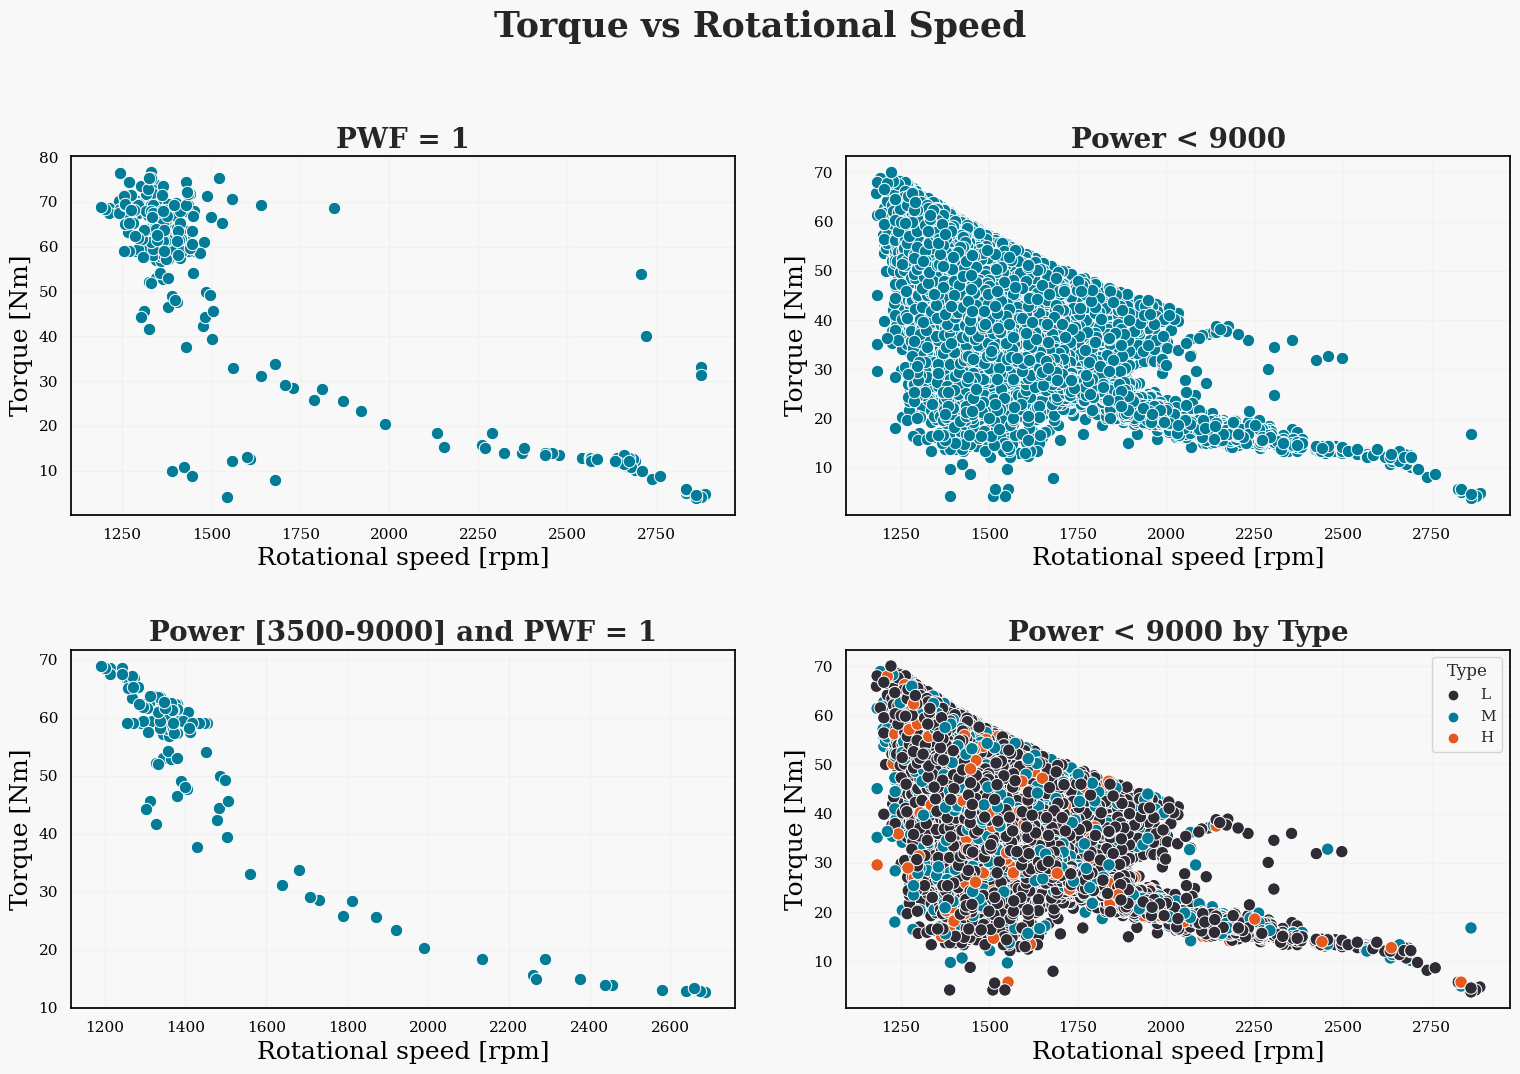

In [25]:
# Calculate power by multiplying Rotational speed (rad/s) and Torque
df['power'] = (df['Rotational speed [rpm]'] * (2 * np.pi / 60)) * df['Torque [Nm]']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(data=df[df['PWF'] == 1], x='Rotational speed [rpm]', y='Torque [Nm]',
                color='#037d97', ax=axes[0, 0], s=80)
axes[0, 0].set_title('PWF = 1', fontsize=20, fontweight='bold')
axes[0, 0].set_xlabel('Rotational speed [rpm]', fontsize=18)
axes[0, 0].set_ylabel('Torque [Nm]', fontsize=18)

sns.scatterplot(data=df[df['power'] < 9000], x='Rotational speed [rpm]', y='Torque [Nm]',
                color='#037d97', ax=axes[0, 1], s=80)
axes[0, 1].set_title('Power < 9000', fontsize=20, fontweight='bold')
axes[0, 1].set_xlabel('Rotational speed [rpm]', fontsize=18)
axes[0, 1].set_ylabel('Torque [Nm]', fontsize=18)

filtered_data = df[(df['power'] > 3500) & (df['power'] < 9000) & (df['PWF'] == 1)]
sns.scatterplot(data=filtered_data, x='Rotational speed [rpm]', y='Torque [Nm]', color='#037d97',
                ax=axes[1, 0], s=80)
axes[1, 0].set_title('Power [3500-9000] and PWF = 1', fontsize=20, fontweight='bold')
axes[1, 0].set_xlabel('Rotational speed [rpm]', fontsize=18)
axes[1, 0].set_ylabel('Torque [Nm]', fontsize=18)

sns.scatterplot(data=df[df['power'] < 9000], x='Rotational speed [rpm]', y='Torque [Nm]',
                color='#037d97', ax=axes[1, 1], s=80, hue="Type", palette=palette)
axes[1, 1].set_title('Power < 9000 by Type', fontsize=20, fontweight='bold')
axes[1, 1].set_xlabel('Rotational speed [rpm]', fontsize=18)
axes[1, 1].set_ylabel('Torque [Nm]', fontsize=18)

fig.suptitle(f'Torque vs Rotational Speed\n\n', ha='center', fontweight='bold', fontsize=25, y=0.92)

plt.tight_layout(pad=3)
plt.show()

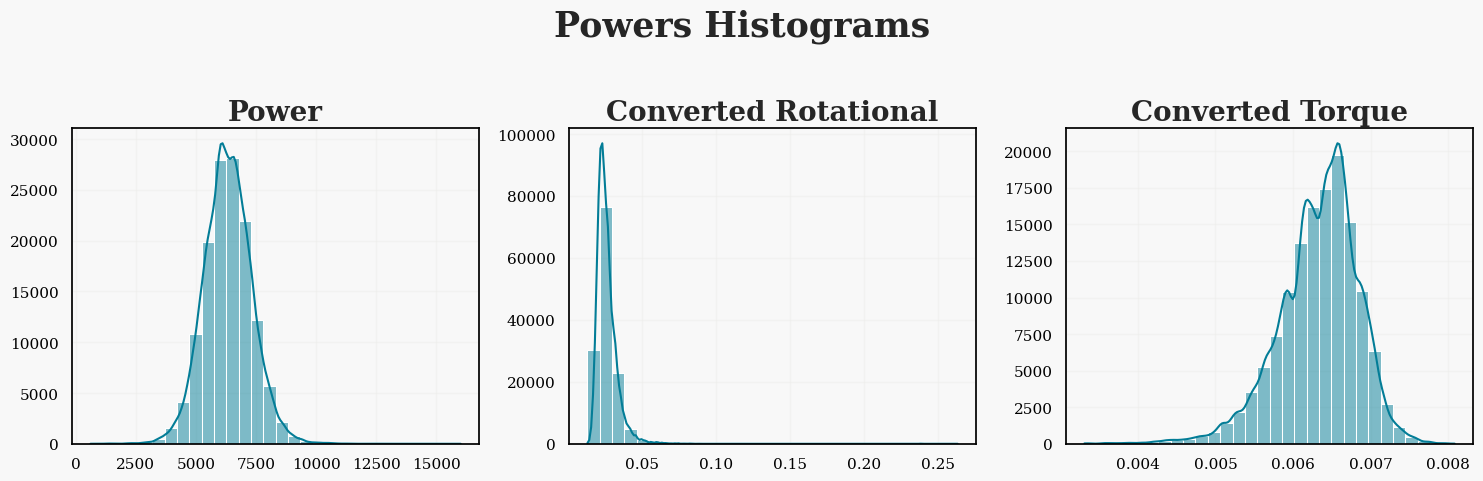

In [26]:
df['speed_power'] = df['Rotational speed [rpm]'] * (2 * np.pi / 60) / (df['Rotational speed [rpm]'] * (2 * np.pi / 60) * df['Torque [Nm]'])
df['torque_power'] = df['Torque [Nm]'] / (df['Rotational speed [rpm]'] * (2 * np.pi / 60) * df['Torque [Nm]'])

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['power'], bins=30, kde=True, color='#037d97')
plt.title('Power', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 2)
sns.histplot(df['speed_power'], bins=30, kde=True, color='#037d97')
plt.title('Converted Rotational', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(df['torque_power'], bins=30, kde=True, color='#037d97')
plt.title('Converted Torque', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

fig.suptitle(f'Powers Histograms\n', ha='center', fontweight='bold', fontsize=25, y=0.96)

plt.tight_layout()
plt.show()

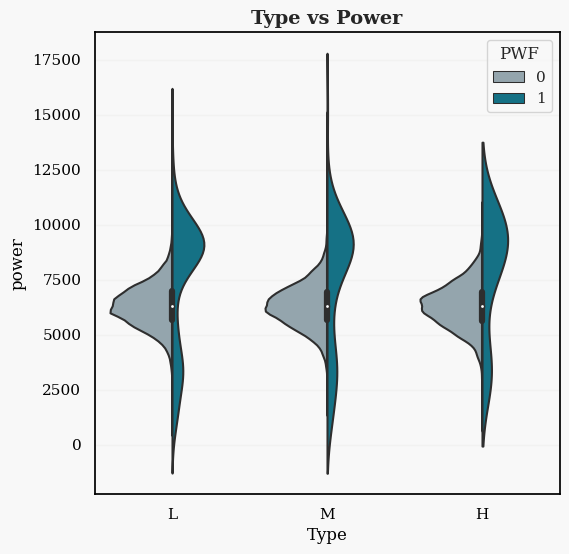

ANOVA Test Results:
F-statistic: 1.043157239250387
p-value: 0.35234331116899764

There is no significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.

Levene's Test Results:
Test statistic: 17.978682152874903
p-value: 1.55950344615656e-08

There is evidence of a significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.


In [27]:
df_pwf = df[['Type', 'Rotational speed [rpm]', 'Torque [Nm]', 'power', 'PWF']]

plt.figure(figsize=(6, 6))
sns.violinplot(data=df_pwf, x='Type', y='power', hue='PWF', split=True, palette=c)
plt.title('Type vs Power', fontsize=14, fontweight='bold')
plt.xlabel('Type', fontsize=12)
plt.ylabel('power', fontsize=12)
plt.legend(title='PWF', loc='upper right')
plt.show()

# one-way ANOVA
result_anova = stats.f_oneway(*(df_pwf[df_pwf['Type'] == t]['power'] for t in df_pwf['Type'].unique()))

print("ANOVA Test Results:")
print("F-statistic:", result_anova.statistic)
print("p-value:", result_anova.pvalue)
print()

alpha = 0.05  # Significance level

if result_anova.pvalue < alpha:
    print("There is evidence of a significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.")
else:
    print("There is no significant difference in the means of 'Rotational speed [rpm]' across different values of 'Type'.")
print()

# Levene's test
result_levene = stats.levene(*(df_pwf[df_pwf['Type'] == t]['Rotational speed [rpm]'] for t in df_pwf['Type'].unique()))

print("Levene's Test Results:")
print("Test statistic:", result_levene.statistic)
print("p-value:", result_levene.pvalue)
print()

alpha = 0.05  # Significance level

if result_levene.pvalue < alpha:
    print("There is evidence of a significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.")
else:
    print("There is no significant difference in the variances of 'Rotational speed [rpm]' across different values of 'Type'.")

This is the first feature we discovered that a normal distribution occurs when machine failure equals 0

***

4) **Overstrain Failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

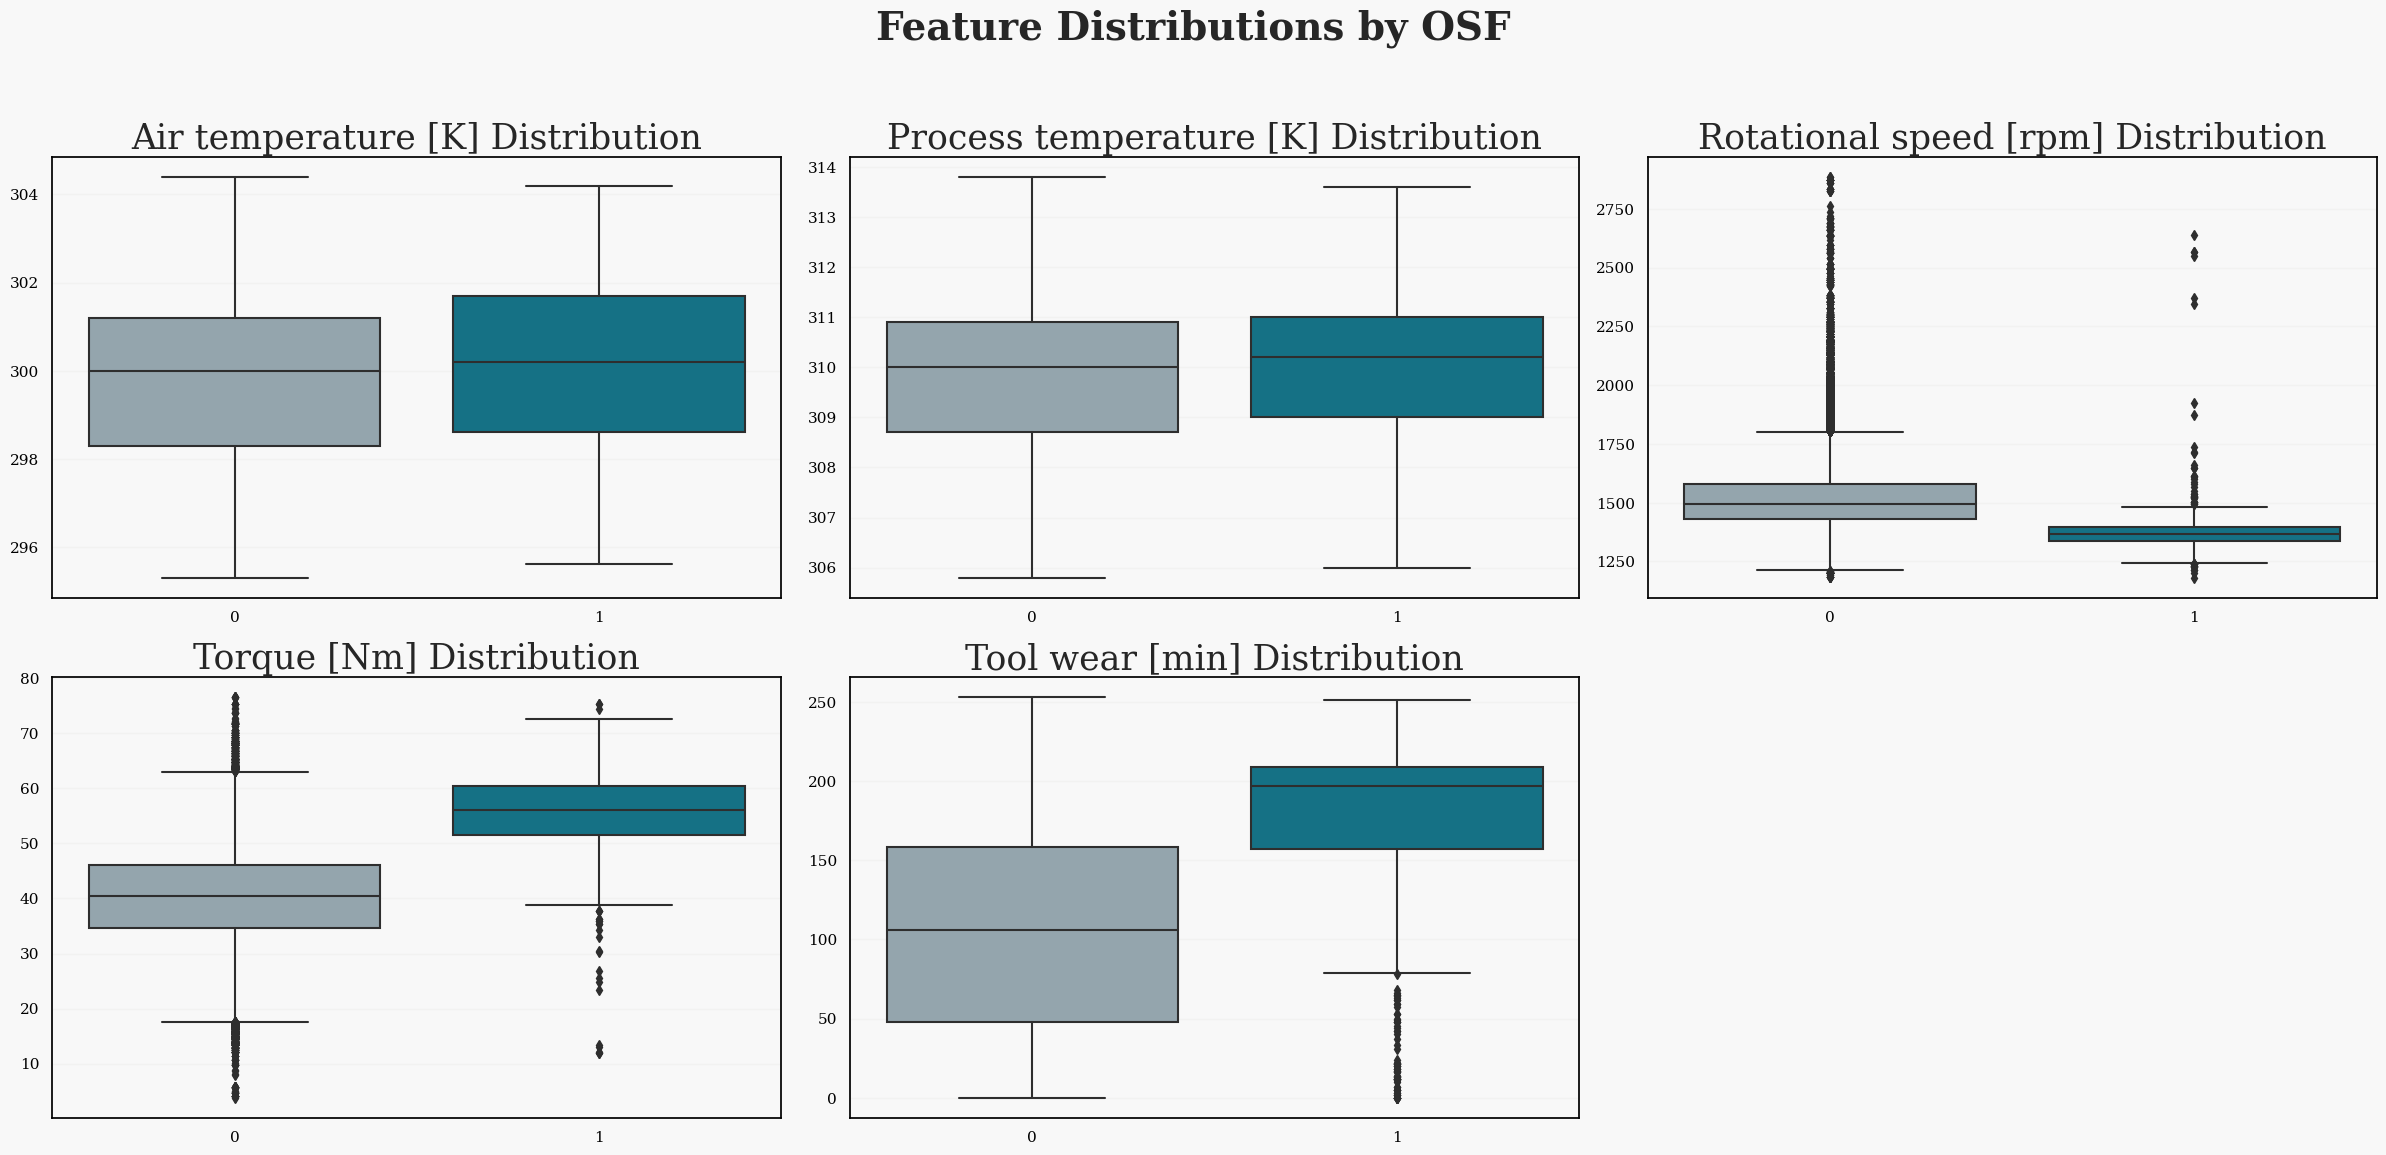

In [28]:
features = [f for f in df.columns if f in num_cols]
columns = features
n_rows = len(columns) // 3
if len(columns) % 3:
    n_rows += 1

fig, ax = plt.subplots(n_rows, 3, figsize=(24, 6 * n_rows))
ax = ax.ravel()

unique_target = df['OSF'].unique()
n_categories = len(unique_target)
colors = sns.color_palette(c, n_categories)

for i, column in enumerate(columns):
    data = [df[df['OSF'] == target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    # titles
    ax[i].set_title(f'{column} Distribution', fontsize=25)
    ax[i].set_xlabel(None, fontsize=20)
    ax[i].set_ylabel(None, fontsize=20)

for i in range(len(columns), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distributions by OSF\n\n', ha='center', fontweight='bold', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

The presence of Overstrain is clearly evident in Torque and Tool Wear box plots. Based on the relationship between Torque and Rotational Speed, we observe that Overstrain is associated with low variance and lower values of Rotational Speed

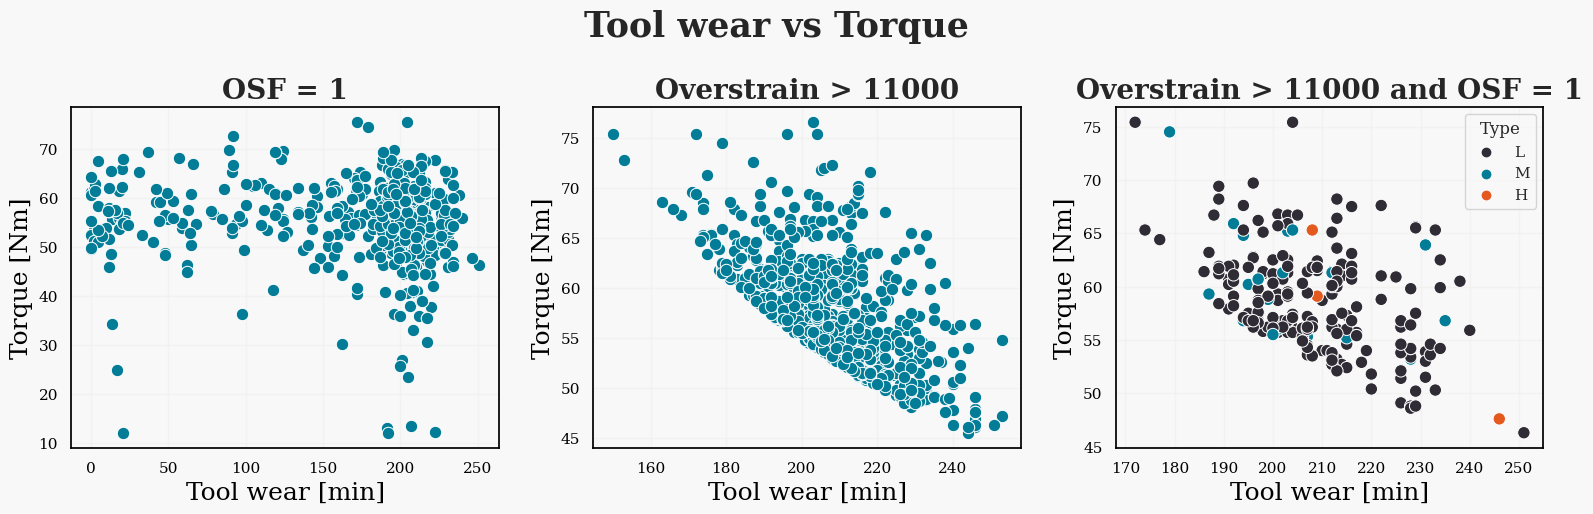

In [29]:
df['overstrain'] = (df['Torque [Nm]'] * df['Tool wear [min]'])

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.scatterplot(data=df[df['OSF'] == 1], x='Tool wear [min]', y='Torque [Nm]',
                color='#037d97', ax=axes[0], s=80)
axes[0].set_title('OSF = 1', fontsize=20, fontweight='bold')
axes[0].set_xlabel('Tool wear [min]', fontsize=18)
axes[0].set_ylabel('Torque [Nm]', fontsize=18)

sns.scatterplot(data=df[df['overstrain'] > 11000], x='Tool wear [min]', y='Torque [Nm]',
                color='#037d97', ax=axes[1], s=80)
axes[1].set_title('Overstrain > 11000', fontsize=20, fontweight='bold')
axes[1].set_xlabel('Tool wear [min]', fontsize=18)
axes[1].set_ylabel('Torque [Nm]', fontsize=18)

filtered_data = df[(df['overstrain'] > 11000) & (df['OSF'] == 1)]
sns.scatterplot(data=filtered_data, x='Tool wear [min]', y='Torque [Nm]', hue='Type',
                palette=palette, ax=axes[2], s=80)
axes[2].set_title('Overstrain > 11000 and OSF = 1', fontsize=20, fontweight='bold')
axes[2].set_xlabel('Tool wear [min]', fontsize=18)
axes[2].set_ylabel('Torque [Nm]', fontsize=18)

fig.suptitle(f'Tool wear vs Torque\n', ha='center', fontweight='bold', fontsize=25, y=0.88)

plt.tight_layout(pad=2.0)
plt.show()

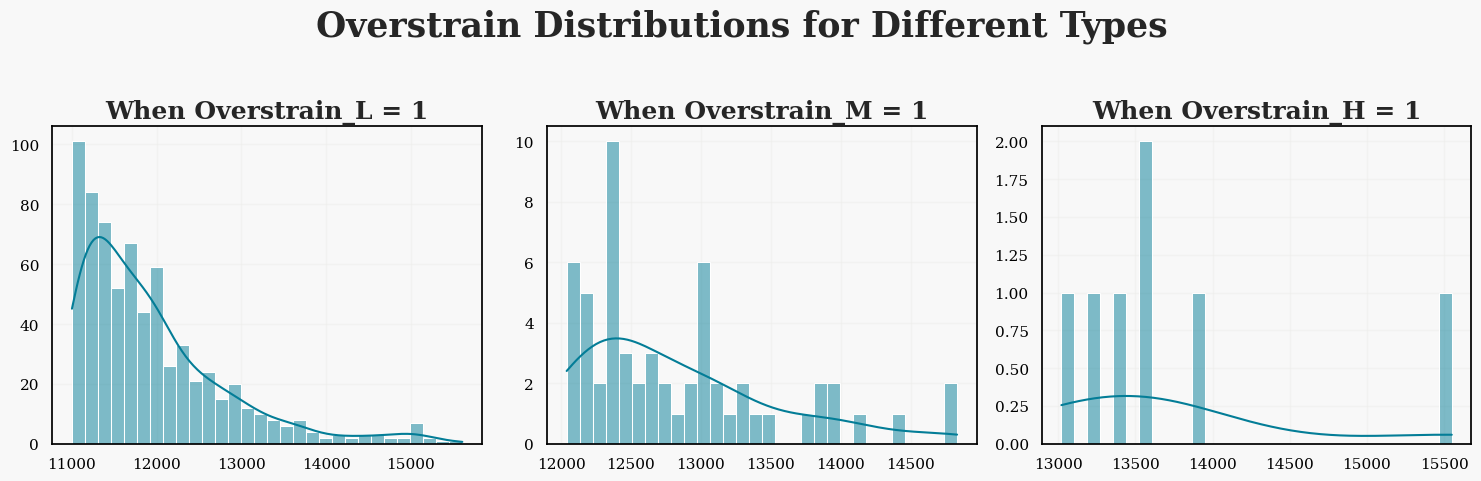

In [30]:
df_copy = df.copy()

df_copy['overstrain_L'] = ((df_copy['overstrain'] > 11000) & (df_copy['Type'] == 'L')).astype(int)
df_copy['overstrain_M'] = ((df_copy['overstrain'] > 12000) & (df_copy['Type'] == 'M')).astype(int)
df_copy['overstrain_H'] = ((df_copy['overstrain'] > 13000) & (df_copy['Type'] == 'H')).astype(int)

fig = plt.figure(figsize=(15, 5))

# overstrain_L = 1
plt.subplot(1, 3, 1)
sns.histplot(df_copy.loc[df_copy['overstrain_L'] == 1, 'overstrain'], bins=30, kde=True, color='#037d97')
plt.title('When Overstrain_L = 1', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

# overstrain_M = 1
plt.subplot(1, 3, 2)
sns.histplot(df_copy.loc[df_copy['overstrain_M'] == 1, 'overstrain'], bins=30, kde=True, color='#037d97')
plt.title('When Overstrain_M = 1', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

# overstrain_H = 1
plt.subplot(1, 3, 3)
sns.histplot(df_copy.loc[df_copy['overstrain_H'] == 1, 'overstrain'], bins=30, kde=True, color='#037d97')
plt.title('When Overstrain_H = 1', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

fig.suptitle(f'Overstrain Distributions for Different Types\n', ha='center', fontweight='bold', fontsize=25, y=0.96)

plt.tight_layout()
plt.show()

## **Product Analysis**
***

Product ID is compose by Type and a serial number.

There are 9979 unique Products IDs and a lot of them shows just one time in the entire dataset. One way to summarize this feature is to take the first 3 digits, which will be called Product Variant.

Now, we have successfully summarized 9979 unique Product IDs into 33 unique Variants.

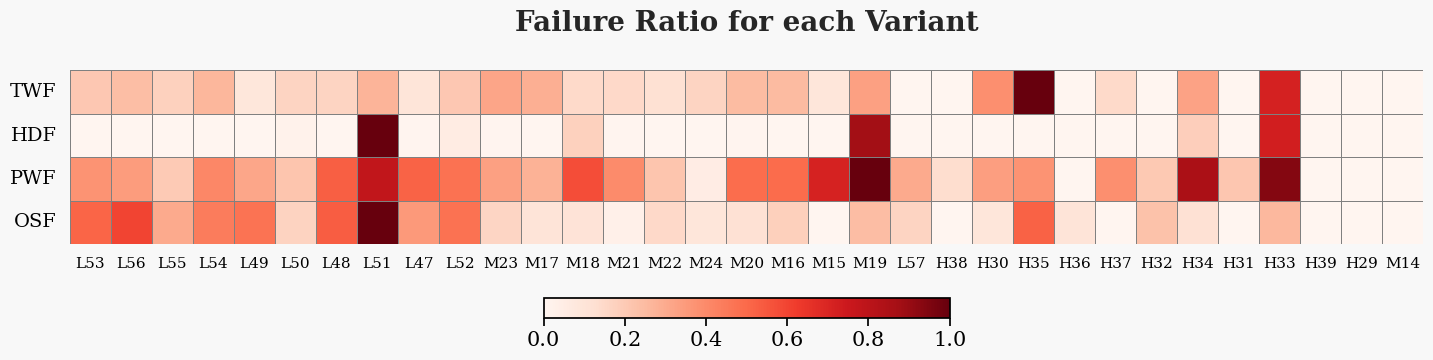

In [31]:
from matplotlib import colors

df['Product Variant'] = df['Product ID'].astype(str).str[:3]
failure_types = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']

group_product = df['Product Variant'].value_counts().reset_index()
group_product.columns = ['Product Variant', 'Count']

for fail in failure_types:
    
    # Sum the failures by product variant
    temp = df.groupby('Product Variant')[fail].sum().reset_index()
    group_product = pd.merge(group_product, temp, on='Product Variant')
    
    # Calculate failure ratio
    group_product[fail + '_ratio'] = (group_product[fail] / group_product['Count'])*100

scaler = MinMaxScaler()
heatmap_failure = group_product.set_index('Product Variant')[['TWF_ratio', 'HDF_ratio', 'PWF_ratio', 'OSF_ratio']]

ratio_cols = ['TWF_ratio', 'HDF_ratio', 'PWF_ratio', 'OSF_ratio']
heatmap_scaled = heatmap_failure.copy()
heatmap_scaled[ratio_cols] = scaler.fit_transform(heatmap_failure[ratio_cols])

heatmap_df_scaled_plot = heatmap_scaled.copy()
heatmap_df_scaled_plot.columns = ['TWF', 'HDF', 'PWF', 'OSF']

fig, ax = plt.subplots(figsize=(14.5,3.7))

cmap = colors.ListedColormap(sns.color_palette("Reds", 256))
norm = colors.Normalize(vmin=0, vmax=1)

sns.heatmap(heatmap_df_scaled_plot.T, cmap=cmap, norm=norm, cbar=False, ax=ax, linecolor='grey', linewidth='0.5')
ax.set_title('Failure Ratio for each Variant\n', weight='bold', fontsize=20)
ax.set_xlabel('', weight='bold')
ax.set_ylabel('', weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=14)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,
                    orientation='horizontal', pad=0.2, shrink=0.3)
cbar.set_label('', weight='bold')
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.show()

Key points:
* The x-axis of the heatmap is organized in descending order based on the dataset count, so L53 is the machine that appears most frequently, while M14 is the least frequent.
*  Practically all of the HDF failures in the dataset are found in the variants L51, M19, and H33. Since this failure occurs in just a few variants, we can theorize that HDF is a good signal for machine failure.
* L51, M19, and H33 are by far the most malfunctioning machines.
* PWF is spread out across every type of machine, while TWF is also present but to a lesser extent.
* Very interesting to observe that OSF is highly prevalent in Type L machines and as the machine quality improves, the occurrence of OSF appears to decrease.
* The machine variants H39, H29, and M14 are the most reliable ones. An interesting observation is that H39 and H29 exhibit machine failure without any apparent cause.

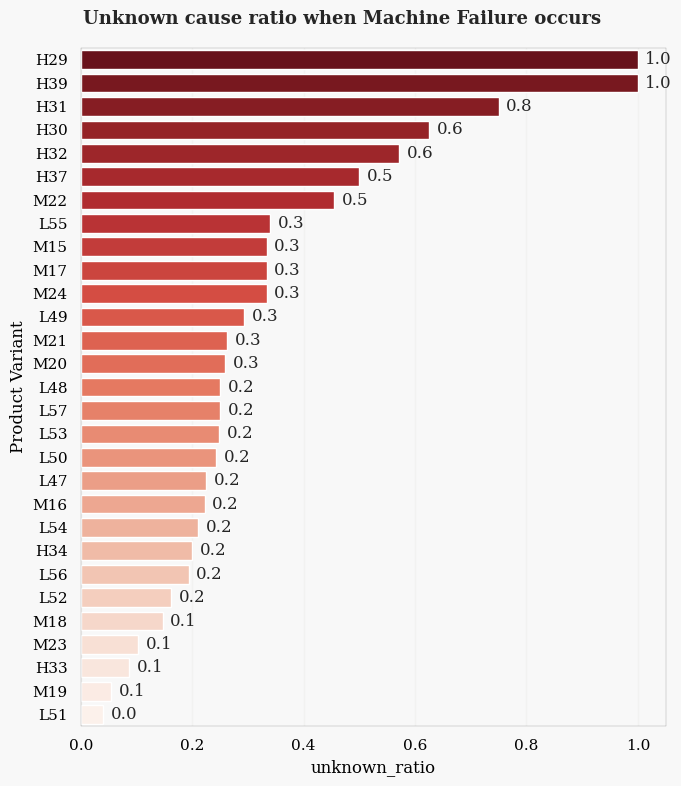

In [32]:
group_product['unknown'] = group_product['Machine failure'] - (group_product['TWF'] + group_product['HDF'] + group_product['PWF'] + group_product['OSF'])
group_product['sum_causes']  = group_product['TWF'] + group_product['HDF'] + group_product['PWF'] + group_product['OSF']
group_product['unknown_ratio'] = group_product['unknown'] / group_product['Machine failure']
group_product['unknown_ratio'] = group_product['unknown_ratio'].apply(lambda x: 0 if pd.isnull(x) or x < 0 else x)

group_product_u = group_product[group_product['unknown_ratio'] > 0]
group_product_u = group_product_u.sort_values('unknown_ratio', ascending=False)

fig, ax = plt.subplots(figsize=(7,8))
bar_plot = sns.barplot(x='unknown_ratio', y='Product Variant', data=group_product_u,
                       palette='Reds_r', ax=ax)

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_width(), '.1f'),
                      (p.get_width(), p.get_y()+p.get_height()/2.),
                      ha = 'center', va = 'center',
                      xytext = (15, 0),
                      textcoords = 'offset points')

for spine in ax.spines.values():
    spine.set_linewidth(0.1)
    
fig.suptitle(f'Unknown cause ratio when Machine Failure occurs', ha='center', fontweight='bold', fontsize=13, y=0.98)
plt.tight_layout()
plt.show()

As stated at the beginning of this notebook, there is an unknown cause at play. This occurs when there is a machine failure but no known failure is triggered. It is important to note that this error is most likely to occur in high-quality machines.

Let's see if this unknown failure has similarities with the failures we already know. A good way to do that is to compare box plots. PWF and TWF are well spread out throughout machine variants, so they can be used. OSF is more likely to occur in L-type machines, but now that we know this unknown factor is present in H-type machines, the lack of OSF seems suspicious.

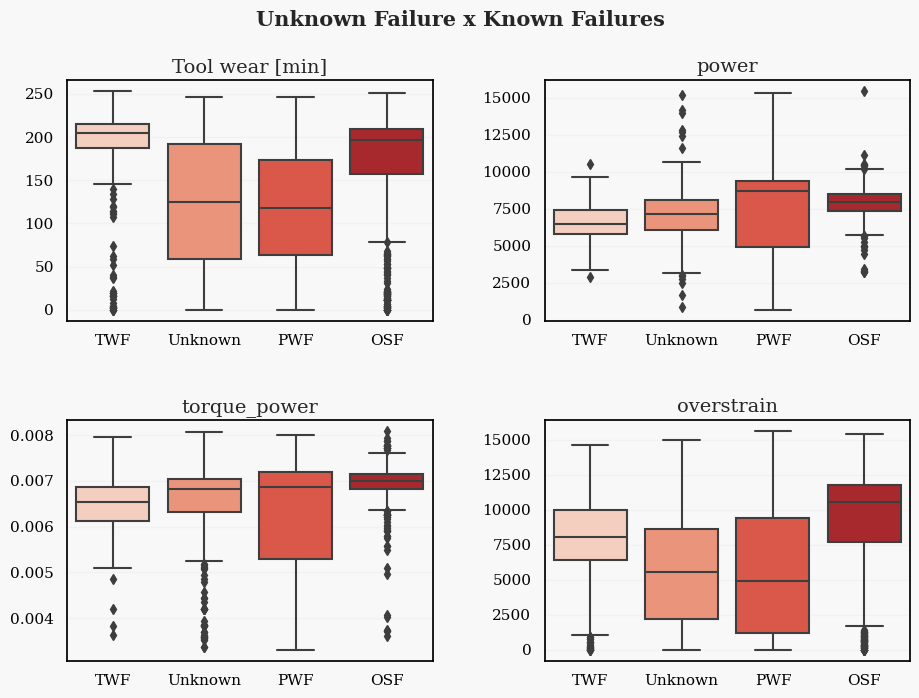

In [33]:
binary_cols = ['TWF','HDF','PWF','OSF']
comp_cols = ['Tool wear [min]', 'power', 'torque_power', 'overstrain']

df['Unknown'] = (df[binary_cols].sum(axis=1) == 0) & (df['Machine failure'] == 1)
df['Unknown'] = df['Unknown'].astype(int)

num_rows = (len(comp_cols) + 1) // 2
fig_width = 10
fig_height = 4 * num_rows

fig, axs = plt.subplots(num_rows, 2, figsize=(fig_width, fig_height))
axs = axs.flatten()

for i, col in enumerate(comp_cols):
    
    data = []
    labels = []
       
    for binary_col in binary_cols:
        if binary_col == 'HDF':
            
            filtered_df = df[df['Unknown'] == 1]
            labels.append('Unknown')
        else:
            
            filtered_df = df[df[binary_col] == 1]
            labels.append(binary_col)            
        
        data.append(filtered_df[col].values)    
    
    sns.boxplot(data=data, ax=axs[i], palette='Reds')
    axs[i].set_title(f"{col}", fontsize='14')
    axs[i].set_xticklabels(labels)
    axs[i].set_xlabel("")
    axs[i].set_ylabel('')

for j in range(len(comp_cols), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle(f'Unknown Failure x Known Failures', 
                 ha='center', fontweight='bold', fontsize=15, y=0.91)
plt.tight_layout(pad=3.0)
plt.show()

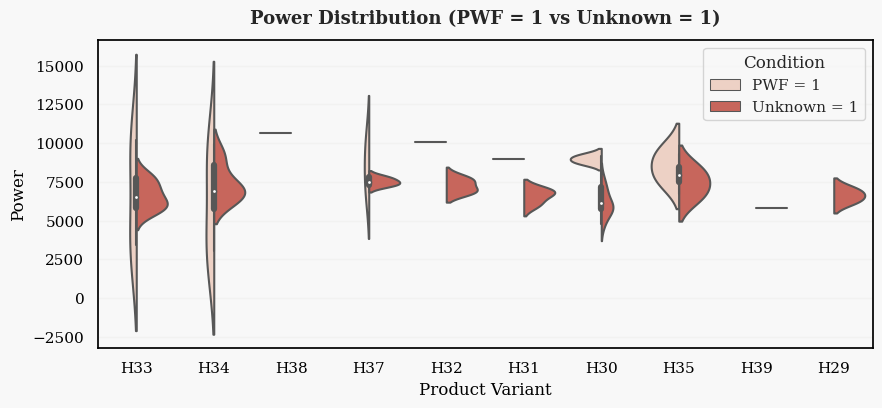

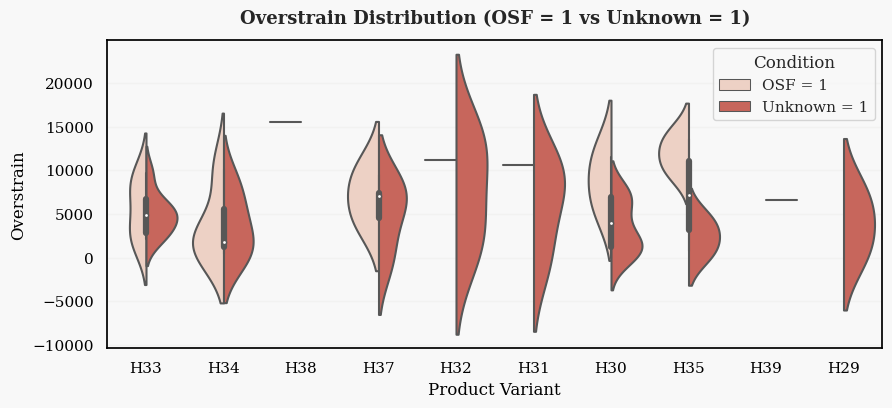

In [34]:
c = ['#f4cebe', '#d9584a']
comp_filtered = df.loc[df['Type'] == 'H', ['Product Variant', 'Unknown', 'PWF', 'OSF', 'overstrain', 'power']]

df_PWF = comp_filtered.loc[comp_filtered['PWF'] == 1, ['Product Variant', 'power']]
df_PWF['Condition'] = 'PWF = 1'

df_Unknown = comp_filtered.loc[comp_filtered['Unknown'] == 1, ['Product Variant', 'power']]
df_Unknown['Condition'] = 'Unknown = 1'

df_concat = pd.concat([df_PWF, df_Unknown])
df_concat.columns = ['Product Variant', 'Power', 'Condition']

plt.figure(figsize=(10, 4))
sns.violinplot(x='Product Variant', y='Power', hue='Condition',
               data=df_concat, split=True, palette=c)
plt.title('Power Distribution (PWF = 1 vs Unknown = 1)\n',
          fontweight='bold', fontsize=13, y=0.96, ha='center')
plt.show()

print("" * 1)

df_OSF = comp_filtered.loc[comp_filtered['PWF'] == 1, ['Product Variant', 'overstrain']]
df_OSF['Condition'] = 'OSF = 1'

df_Unknown = comp_filtered.loc[comp_filtered['Unknown'] == 1, ['Product Variant', 'overstrain']]
df_Unknown['Condition'] = 'Unknown = 1'

df_concat = pd.concat([df_OSF, df_Unknown])
df_concat.columns = ['Product Variant', 'Overstrain', 'Condition']

plt.figure(figsize=(10, 4))
sns.violinplot(x='Product Variant', y='Overstrain', hue='Condition',
               data=df_concat, split=True, palette=c)
plt.title('Overstrain Distribution (OSF = 1 vs Unknown = 1)\n',
          fontweight='bold', fontsize=13, y=0.96, ha='center')
plt.show()

Key points:
* The general overview given by the box plots suggests that the distribution of 'Unknown' is similar to 'PWF.
* The violin plots resolve the mystery behind the lack of 'OSF' in H-type machines. It appears that for these instances, 'Unknown' may actually represent 'OSF'.
* We could theorize that 'Unknown' is actually a mixture of 'PWF' and 'OSF' that were not correctly labeled, or more likely, were generated during the creation of the synthetic data.

## **Decomposition**
***

In [35]:
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from umap import UMAP

p = ['#302c36', '#E4591E','#6ca957', '#037d97']

# Inspired on @tetsutani code
def scale_data(df, method="standard"):
    _df = df.copy()
    if method == "standard":
        return StandardScaler().fit_transform(_df)
    elif method == "minmax":
        return MinMaxScaler().fit_transform(_df)
    elif method is None:
        return _df.values
    else:
        raise ValueError(f"Invalid scaler_method name")

def reduce_dimension(X, n_components, method="pca"):
    if method == "pca":
        comp = PCA(n_components=n_components, random_state=11)
    elif method == "nmf":
        comp = NMF(n_components=n_components, random_state=11)
    elif method == "umap":
        comp = UMAP(n_components=n_components, random_state=11)
    elif method == "svd":
        comp = TruncatedSVD(n_components=n_components, random_state=11)
    else:
        raise ValueError(f"Invalid method name: {method}")

    X_reduced = comp.fit_transform(X)
    return X_reduced, comp

def generate_column_names(n_components, method="pca"):
    return [f'{method.upper()}_{_}' for _ in range(n_components)]

def plot_decomp(data, method, ax):
    method = method.upper() 
    data_melted = data.melt(id_vars=[f"{method}_0", f"{method}_1"], value_vars=binary_cols,
                            var_name='variable', value_name='value')
    data_melted = data_melted[data_melted['value'] == 1]  
    sns.scatterplot(x=f"{method}_0", y=f"{method}_1", hue='variable', data=data_melted, alpha=0.7,
                    s=55, palette=p, ax=ax)
    ax.set_title(f'{method} ', fontsize=18)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel(f"{method} Component 1", fontsize=14)
    ax.set_ylabel(f"{method} Component 2", fontsize=14)
    legend = ax.legend(prop={'size': 10})

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

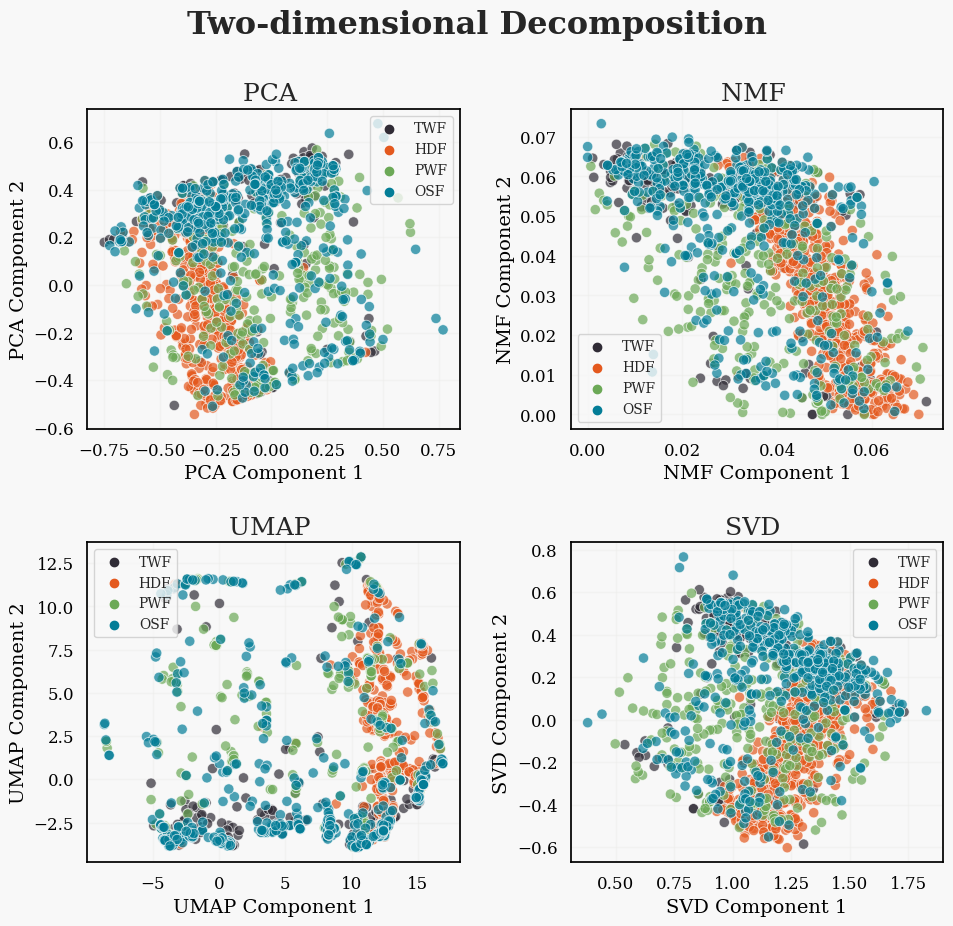

In [36]:
df_copy = df.copy()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, method in enumerate(['pca', 'nmf', 'umap', 'svd']):
    X_scaled = scale_data(df_copy[num_cols], method="minmax")
    X_reduced, _ = reduce_dimension(X_scaled, n_components=2, method=method)
    
    column_names = generate_column_names(n_components=2, method=method)
    tmp = pd.DataFrame(X_reduced, columns=column_names, index=df_copy.index)
    
    tmp = pd.concat([df_copy, tmp], axis=1)
    plot_decomp(tmp, method, axs[i//2, i%2])

plt.suptitle(f"Two-dimensional Decomposition\n", fontsize=23, fontweight='bold', y=0.94)
plt.tight_layout(pad=2.0)
plt.show()

It seems that failure modes does not have a strong relationship with the structure of the high-dimensional data

## **Features Used**
***

**Temperatures**

* `Difference in Temperature`: Air temperature - Process temperature
* `Temperature Ratio`: Process temperature / Air temperature
* `Tool Process Temperature`: Process temperature * Tool Wear

**Power**

* `Rotation to Power`: Rotation ~ Torque interaction
* `Torque to Power`: Torque ~ Rotation interaction

**Categorical**

* `Type`: Label Encoded
* `Product ID`: Transform to numeric 

**Obs:** As I explain [in this discussion](http://https://www.kaggle.com/competitions/playground-series-s3e17/discussion/417883) It's not necessary to transform air temperature and process temperature from Kelvin to Celsius. Creating a new feature by subtracting a constant value from an existing feature will not change the distribution. It will only change the units of measurement.

This kind of transformation is linear, which preserves the shape and characteristics of the distribution, such as the mean, standard deviation, and skewness.

For example, if the original feature followed a normal distribution with a mean of 300 Kelvin and a standard deviation of 10 Kelvin, this new created feature will follow a normal distribution with the same mean of 300 Celsius and the same standard deviation of 10 Celsius.

In [37]:
df_1.drop(columns='id', inplace=True)
original_1.drop(columns='UDI', inplace=True)

test.drop(columns='RNF', inplace=True)
df_1.drop(columns='RNF', inplace=True)
original_1.drop(columns='RNF', inplace=True)

data_all = pd.concat([df_1, original_1], ignore_index=True)

data_all['air_process_diff'] = abs(data_all['Air temperature [K]'] - data_all['Process temperature [K]'])
test['air_process_diff'] = abs(test['Air temperature [K]'] - test['Process temperature [K]'])

data_all['speed_power'] = data_all['Rotational speed [rpm]'] * (2 * np.pi / 60) / (data_all['Rotational speed [rpm]'] * (2 * np.pi / 60) * data_all['Torque [Nm]'])
test['speed_power'] = test['Rotational speed [rpm]'] * (2 * np.pi / 60) / (test['Rotational speed [rpm]'] * (2 * np.pi / 60) * test['Torque [Nm]'])

data_all['torque_power'] = data_all['Torque [Nm]'] / (data_all['Rotational speed [rpm]'] * (2 * np.pi / 60) * data_all['Torque [Nm]'])
test['torque_power'] = test['Torque [Nm]'] / (test['Rotational speed [rpm]'] * (2 * np.pi / 60) * test['Torque [Nm]'])

data_all["tool_process"]=data_all["Tool wear [min]"] * data_all["Process temperature [K]"]
test["tool_process"]=test["Tool wear [min]"] * test["Process temperature [K]"]

data_all["temp_ratio"] = data_all["Process temperature [K]"] / data_all["Air temperature [K]"]
test["temp_ratio"] = test["Process temperature [K]"] / test["Air temperature [K]"]

data_all["product_id_num"] = pd.to_numeric(data_all["Product ID"].str.slice(start=1))
test["product_id_num"] = pd.to_numeric(test["Product ID"].str.slice(start=1))

In [38]:
data_all.drop(columns='Product ID', inplace=True)
test.drop(columns='Product ID', inplace=True)

le = LabelEncoder()
for col in cat_columns:
    data_all['encoded_' + col] = le.fit_transform(data_all[col])
        
data_all.drop(cat_columns, axis=1, inplace=True)

for col in cat_columns:
    test['encoded_' + col] = le.transform(test[col])

test.drop(cat_columns, axis=1, inplace=True)

data_all.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                300.6                    309.6                    1596   
1                302.6                    312.1                    1759   
2                299.3                    308.5                    1805   
3                301.0                    310.9                    1524   
4                298.0                    309.0                    1641   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  \
0         36.1              140                0    0    0    0    0   
1         29.1              200                0    0    0    0    0   
2         26.5               25                0    0    0    0    0   
3         44.3              197                0    0    0    0    0   
4         35.4               34                0    0    0    0    0   

   air_process_diff  speed_power  torque_power  tool_process  temp_ratio  \
0               9.0     0.027701      0.005983       43344.0    1.029940   
1               9.5     0.034364      0.005429       62420.0    1.031395   
2               9.2     0.037736      0.005290        7712.5    1.030738   
3               9.9     0.022573      0.006266       61247.3    1.032890   
4              11.0     0.028249      0.005819       10506.0    1.036913   

   product_id_num  encoded_Type  
0           50096             1  
1           20343             2  
2           49454             1  
3           53355             1  
4           24050             2

## **XGB Model**
***

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

X = data_all.drop("Machine failure", axis=1)
y = data_all["Machine failure"]
X.columns = [re.sub(r"[^a-zA-Z0-9_]+", "_", col) for col in X.columns]
final_valid_predictions = []
oof_targets = []

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.85, random_state=42)

xgb = XGBClassifier(n_estimators=1500, 
                    objective='binary:logistic', 
                    eval_metric='auc', 
                    random_state=42, 
                    learning_rate = 0.08719877907815099, 
                    subsample = 0.9225106653522045, 
                    colsample_bytree = 0.212545425027345,
                    max_depth = 8
                    )

xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_val, y_val)], verbose=100)
y_pred = xgb.predict_proba(X_val)[:, 1]

final_valid_predictions.extend(y_pred)
oof_targets.extend(y_val)

oof_preds = np.array(final_valid_predictions)
oof_targets = np.array(oof_targets)

feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
features = X.columns

roc_score = roc_auc_score(oof_targets, oof_preds)
print(f"Final ROC AUC score: {roc_score}")

[0]	validation_0-auc:0.86790
[100]	validation_0-auc:0.97423
[200]	validation_0-auc:0.97599
[300]	validation_0-auc:0.97475
Final ROC AUC score: 0.976050750993742


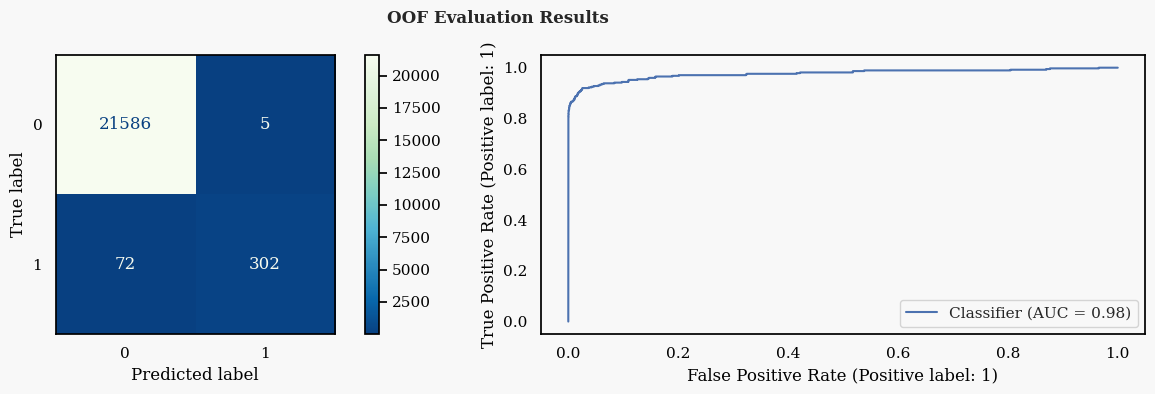

In [40]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

def show_confusion_roc(oof, title='Model Evaluation Results'):
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.stack([oof[0], oof[1]]), index=['preds', 'target']).T
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='GnBu_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.grid()

show_confusion_roc(oof=[oof_preds, oof_targets], title='OOF Evaluation Results')

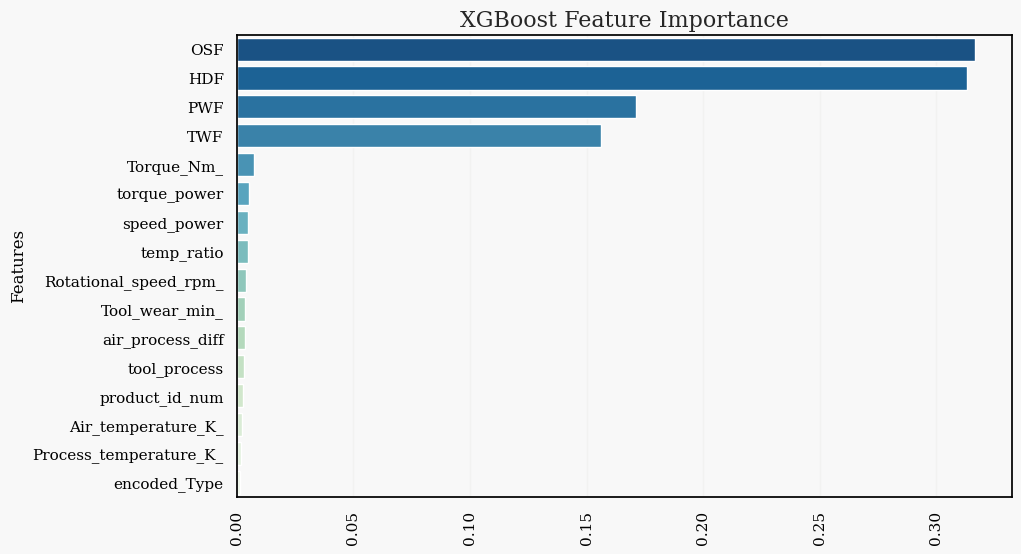

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=np.array(features)[sorted_idx], palette='GnBu_r')
plt.xlabel("")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance", fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

## **Submission**
***

In [42]:
test.columns = [re.sub(r"[^a-zA-Z0-9_]+", "_", col) for col in test.columns]
test_predictions = xgb.predict_proba(test)
predicted_prob = [pred[1] for pred in test_predictions]
predicted_prob[:5]

submission['Machine failure'] = predicted_prob

In [43]:
submission

id  Machine failure
0      136429         0.000683
1      136430         0.004748
2      136431         0.000518
3      136432         0.000823
4      136433         0.001409
...       ...              ...
90949  227378         0.000860
90950  227379         0.000431
90951  227380         0.002266
90952  227381         0.000855
90953  227382         0.001387

[90954 rows x 2 columns]

In [44]:
submission.to_csv(r"submission.csv", index=False)